# 第4章 多层感知机

## 4.1 多层感知机

### 练习4.1.1

计算$pReLU$激活函数的导数。

**解答：** 

&emsp;&emsp;由
$$
pReLU(x)= \begin{cases}x & \text { if } x>=0 \\ \alpha x  & \text { if } x<0 \end{cases}
$$

&emsp;&emsp;可得
$$ 
\frac{d}{d x} pReLU(x)= \begin{cases}1 & \text { if } x>=0 \\ \alpha   & \text { if } x<0 \end{cases}
$$

&emsp;&emsp;以下使用画图展示：

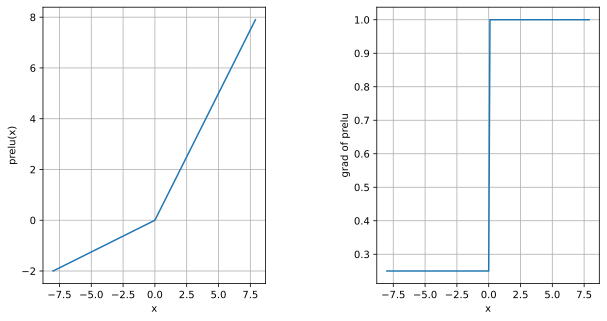

In [6]:
# matplotlib 绘图会直接嵌入到 notebook 中，并且会在代码块下方显示图形输出
%matplotlib inline
import torch
from d2l import torch as d2l
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True) # 创建一个张量，该张量包含从-8.0开始到8.0结束（不包括8.0），步长为0.1的一系列数。requires_grad=True 表示创建的张量会跟踪其在计算图中的梯度，这意味着在进行反向传播时，PyTorch 会自动计算这个张量的梯度
y = torch.prelu(x,weight=torch.tensor(0.25))
d2l.plt.figure(figsize=(10, 5)) 
d2l.plt.subplot(121) # 用于创建子图的函数。这个函数的参数表示将图形分割成1行2列，并选择第一个子图来绘制
d2l.plot(x.detach(), y.detach(), 'x', 'prelu(x)', figsize=(5, 2.5))
d2l.plt.subplot(122)
y.backward(torch.ones_like(x), retain_graph=True)  # PyTorch会根据链式法则计算y对x的梯度。其中torch.ones_like(x)表示创建一个和x相同shape的张量，并且填充为1，这个张量是y对x的梯度的初始值。retain_graph=True表示在计算完梯度后保留计算图，这样可以多次调用backward函数进行梯度计算，而不需要重新构建计算图。
d2l.plot(x.detach(), x.grad, 'x', 'grad of prelu', figsize=(5, 2.5))
d2l.plt.subplots_adjust(wspace =0.5, hspace =0) # 调整子图之间间距的函数。其中wspace表示子图之间的宽度间距，hspace表示子图之间的高度间距

### 练习4.1.2

证明一个仅使用$ReLU$（或$pReLU$）的多层感知机构造了一个连续的分段线性函数。

**解答：**

&emsp;&emsp;这道题的答案和一个著名的universal approximation theory 有关 该定理指出 只含有一层隐藏层的神经网络可以任意精度逼近任何一个连续函数。相关的定理证明可以参考下面的文章。
Pinkus, Allan (January 1999). ["Approximation theory of the MLP model in neural networks"](https://www.cambridge.org/core/journals/acta-numerica/article/abs/approximation-theory-of-the-mlp-model-in-neural-networks/18072C558C8410C4F92A82BCC8FC8CF9)

&emsp;&emsp;数学上具体证明比较繁琐，但我们可以通过一个简单的小例子，感性地理解universal approximation theory的为什么可以成立。同时，我们还可以通过程序来验证它的准确性。

&emsp;&emsp;1.为了启发思考我们可以通过一个简单小的例子，理解universal approximation theory。
如图（图片来自李宏毅老师课程的[讲义](http://speech.ee.ntu.edu.tw/~tlkagk/courses_MLDS18.html) 不过经过修改原讲义处有错误）所示对于下图中蓝色的实线表示的“折线函数”，我们可以用两个$relu$神经元很好的拟合。

&emsp;&emsp;为了启发思考我们先考虑一个简单小的例子
如图所示对于下图中蓝色的实线表示的“折线函数”，我们可以用两个$relu$神经元很好的拟合。

![relu](../../images/ch4-4-1-2-relu.png)

&emsp;&emsp;上面的例子说明任何小段“折线函数”我们可以用$relu$拟合，而任意的函数我们总能把他分成一小段“折线函数”，从用多个$relu$拟合它。

&emsp;&emsp;2.利用代码实现用仅含有$Relu$的感知机拟合一个如下式所示的分段连续函数
$$
f(x)^*= \begin{cases}a_1 x^{n_1}+b_1, & 0 \leq x \leq 4  \\ a_2 x^{n_2}+b_2, & 4 < x \leq 8 \\ a_3 x^{n_3}+b_3, & 8 < x \leq 12 \\  \end{cases}
$$
&emsp;&emsp;这里为了方便起见令$a_1,a_2,a_3,n_1,n_2,n_3 \in [0,3],x\in[0,12] ,f(x)^* \in [0,1]$

epoch 10, loss 0.000382


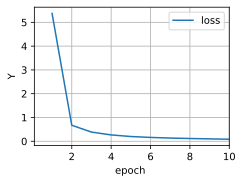

In [9]:
import random
from d2l import torch as d2l
import numpy as np
import torch
from torch import nn
#定义函数
a1,b1,n1,a2,n2,a3,n3=[ 3*random.random() for _ in range(7) ] #定义函数系数 从0到3中随机抽取
b2= a1*(4**n1)+b1 -a2*(4**n2)#
b3=a2*(8**n2)+b2-a3*(8**n3)#
def f_star(x):
    n=(a3*(12**n3)+b3);
    if x <=4.0 :
        return (a1*(x**n1)+b1)/n
    if 4.0<x<=8.0:
        return (a2*(x**n2)+b2)/n
    if 8.0<x<=12.0:
        return (a3*(x**n3)+b3)/n
    
#构建数据集   d2l.load_array介绍可以参看3.3     
x=torch.arange(0.0,12.0, 0.0001).reshape(-1,1)
batch_size=100;
train_iter=d2l.load_array((x,torch.tensor([f_star(i) for i in x]).reshape(-1,1)),batch_size) 

#定义网络后面的小节有相关内容参看4.3
net = nn.Sequential(nn.Flatten(),
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 1))
#初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);
batch_size, lr, num_epochs = 10, 0.1, 10
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
#绘制loss和epoch图
num_epochs = 10
animator = d2l.Animator(xlabel=f'epoch ',ylabel='Y', xlim=[0.1, num_epochs],
                        legend=['loss'])
for epoch in range(num_epochs):
    L=0
    for X, y in train_iter:
        
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        l = loss(net(X), y)
        L+=l.detach().numpy()
    L=L/batch_size
    animator.add(epoch + 1, (L,))
    print(f'epoch {epoch + 1}, loss {l:f}')


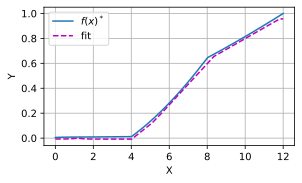

In [10]:
#比较拟合的网络和原函数
y1=torch.tensor([f_star(i) for i in x]).detach().numpy()
y2=torch.squeeze(net(x).detach().reshape(1,-1)).numpy()
d2l.plot(np.arange(0.0,12.0, 0.0001), [y1,y2],legend=['$f(x)^*$','fit'], figsize=(4.5, 2.5))
d2l.plt.xlabel("X");
d2l.plt.ylabel("Y");

### 练习4.1.3
证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。

**解答：** 

&emsp;&emsp;已知：$$
\operatorname{tanh}(x)=\frac{1 - \exp(-2x)}{1 + \exp(-2x)}
$$

&emsp;&emsp;故左式：$$\operatorname{tanh}(x) + 1 =\frac{1 - \exp(-2x)}{1 + \exp(-2x)}+1= \frac{2}{1 + \exp(-2x)}$$   

&emsp;&emsp;同时有$$\operatorname{sigmoid}(2x)= \frac{1}{1 + \exp(-2x)}$$ 
&emsp;&emsp;故易证 左式=右式

&emsp;&emsp;以下使用`torch`编程进行验证：

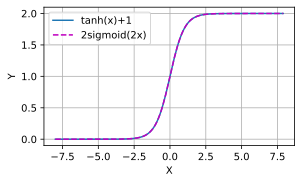

In [11]:
#加载包见4.1.1
x = torch.arange(-8.0, 8.0, 0.1)
y1 = torch.tanh(x)+1.0
y2 = 2.0*torch.sigmoid(2.0*x)


d2l.plot(x.detach().numpy(), [y1.detach(), y2.detach()],
         legend=['tanh(x)+1','2sigmoid(2x)'], figsize=(4.5, 2.5))
d2l.plt.xlabel("X");
d2l.plt.ylabel("Y");

### 练习4.1.4

假设我们有一个非线性单元，将它一次应用于一个小批量的数据。这会导致什么样的问题？

**解答：**

&emsp;&emsp;将非线性单元一次应用于一个小批量的数据可能会导致以下问题：

1. 信息丢失：非线性单元通常引入非线性变换，将输入数据映射到新的表示空间。当应用于小批量的数据时，可能会存在数据样本之间的相关性和多样性不足的问题。这可能导致一部分样本的信息丢失或被模糊化，因为小批量数据可能无法充分捕捉到全局数据分布的特征。

2. 噪声放大：小批量数据通常包含相对较少的样本，其中可能存在噪声或异常值。当非线性单元应用于这些数据时，噪声和异常值可能被放大，导致输出结果出现不稳定或错误的情况。

3. 参数更新不准确：在训练神经网络时，通过反向传播算法进行参数更新。当应用非线性单元于小批量数据时，由于数据的有限性，可能导致梯度估计的不准确性。这可能影响参数的更新过程，使得网络收敛速度变慢或无法达到最佳状态。

4. 过拟合风险增加：小批量数据的样本量较少，这可能增加过拟合的风险。由于小批量数据可能无法充分代表整体数据分布，模型可能更容易过度拟合训练集，导致泛化性能下降。

&emsp;&emsp;为了缓解这些问题，可以考虑以下方法：

- 增加小批量数据的样本量，以更好地代表整体数据分布。
- 使用正则化技术（如L1或L2正则化）来控制模型的复杂度，减少过拟合风险。
- 使用数据增强技术来扩充小批量数据的多样性，增加训练样本的数量和质量。
- 采用批归一化等技术来规范化输入数据，以减小噪声的影响。
- 如果可行，考虑使用更大的批量数据来提高模型性能和稳定性。

## 4.2 多层感知机的从零开始实现

### 练习4.2.1

在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。

**解答：**  

&emsp;&emsp;256到376范围内`num_hiddens`得到结果测试准确率在0.83和0.85附近震荡。取`num_hiddens=256`，能保证其他参数不变时得到最佳的结果。

&emsp;&emsp;以下使用`torch`编程进行实验：

In [3]:
import torch
from d2l import torch as d2l
from torch import nn
train_iter, test_iter = d2l.load_data_fashion_mnist(256, resize=None)

def initweight4_2_1(num_inputs=784, num_outputs=10, num_hiddens = 256):
    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01) # PyTorch中的nn.Parameter函数创建了一个需要梯度的模型参数。torch.randn(num_inputs, num_hiddens)生成一个大小为num_inputs x num_hiddens的张量，其中的值是从均值为0，方差为1的正态分布中随机采样得到的。接着乘以0.01，这是一个常见的权重初始化方法，目的是将权重初始化为一个比较小的值，以便在训练过程中更快地收敛。最后，使用nn.Parameter将这个张量转换为模型的可学习参数，这意味着在训练过程中，PyTorch会自动计算这个参数的梯度，并更新它的数值。
    b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
    W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params = [W1, b1, W2, b2]
    return W1,b1,W2,b2, params

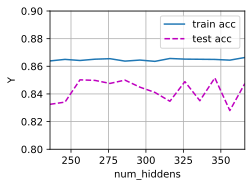

In [4]:
showtrain=0 #showtrain-1 可以展示训练过程的情况
num_inputs=784
num_outputs=10
num_hiddenslist=list(range(236,376,10))
animatornum_hiddens = d2l.Animator(xlabel='num_hiddens',ylabel='Y',xlim=[num_hiddenslist[0],num_hiddenslist[-1]], ylim=[0.8, 0.9],
                        legend=[ 'train acc', 'test acc'])
for num_hiddens in num_hiddenslist:
    num_epochs, lr = 10, 0.1
    loss = nn.CrossEntropyLoss(reduction='none')
    W1,b1,W2,b2, params=initweight4_2_1(num_inputs=num_inputs, num_outputs=num_outputs, num_hiddens=num_hiddens)
    updater = torch.optim.SGD(params, lr=lr)
    def relu(X):
        a = torch.zeros_like(X)
        return torch.max(X, a)
    def net(X):
        X = X.reshape((-1, num_inputs))
        H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
        return (H@W2 + b2)
    if showtrain==1:
        animator =d2l.Animator(xlabel=f'epoch num_hiddens:{num_hiddens}',ylabel='Y',xlim=[1, num_epochs], ylim=[0.25, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        if showtrain==1:
            animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(f'num_hiddens={num_hiddens},train_loss={train_loss}, train_acc={train_acc},test_acc={test_acc}')
    animatornum_hiddens.add(num_hiddens,(train_acc,test_acc))
    assert train_loss < 0.5, train_loss  # assert语法：assert expression [, arguments] ，如果expression不成立，则输出arguments
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    


### 练习4.2.2
尝试添加更多的隐藏层，并查看它对结果有何影响。

**解答：**

&emsp;&emsp;在其他参数不变的情况下单纯增加隐藏层数会减少准确率。

&emsp;&emsp;以下使用`torch`编程进行实验：

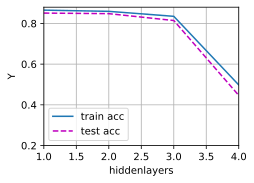

In [12]:
#import见4.2.1
train_iter, test_iter = d2l.load_data_fashion_mnist(256, resize=None)

def initweight4_2_2(num_inputs=784, num_outputs=10, num_hiddens = 256,num_hiddenlayers=1):
    params=[]
    for i in range(num_hiddenlayers):
            a=num_inputs if i==0 else num_hiddens
            b=num_hiddens
            params.append(nn.Parameter(torch.randn(a, b, requires_grad=True) * 0.01))
            params.append(nn.Parameter(torch.zeros(b, requires_grad=True)))
    params.append(nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01))
    params.append(nn.Parameter(torch.zeros(num_outputs, requires_grad=True)))       
    return params
showtrain=0 # showtrain-1 可以展示训练过程的情况
num_inputs=784
num_outputs=10
num_hiddens = 256
num_hiddenlayerslist=list(range(1,5))
animatornum_hiddenlayers = d2l.Animator(xlabel='hiddenlayers',ylabel='Y',xlim=[num_hiddenlayerslist[0],num_hiddenlayerslist[-1]], ylim=[0.2, 0.88],
                        legend=[ 'train acc', 'test acc'])
for num_hiddenlayers in num_hiddenlayerslist:
    num_epochs, lr = 10, 0.1
    loss = nn.CrossEntropyLoss(reduction='none')
    params=initweight4_2_2(num_inputs=num_inputs, num_outputs=num_outputs, num_hiddens=num_hiddens,num_hiddenlayers=num_hiddenlayers)
    updater = torch.optim.SGD(params, lr=lr)
    def relu(X):
        a = torch.zeros_like(X)
        return torch.max(X, a)
    def net(X):
        X = X.reshape((-1, num_inputs))
        H = relu(X@params[0] + params[1])
        for i in range(2,2*num_hiddenlayers ,2):
            H = relu(H@(params[i]) + params[i+1])  # 这里“@”代表矩阵乘法
        return (H@(params[-2]) + params[-1])
    if showtrain==1:
        animator =d2l.Animator(xlabel=f'epoch num_hiddenlayers:{num_hiddenlayers}',ylabel='Y',xlim=[1, num_epochs], ylim=[0.25, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        if showtrain==1:
            animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(f'num_hiddenlayers={num_hiddenlayers},train_loss={train_loss}, train_acc={train_acc},test_acc={test_acc}')
    animatornum_hiddenlayers.add(num_hiddenlayers,(train_acc,test_acc))
    
    

### 练习4.2.3

改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？

**解答：** 

&emsp;&emsp;较大的学习速率可以让loss下降更快，在初期更快的训练模型，但也可能造成更新参数值过大 ,导致参数在最优解附近来回跳跃无法收敛或者收敛在错误的值,同时过小的学习率会要求更多的训练轮数以达到收敛。最理想的学习率不是固定值, 而是一个随着训练次数衰减的变化的值, 也就是在训练初期, 学习率比较大, 随着训练的进行, 学习率不断减小, 直到模型收敛.

&emsp;&emsp;以下使用`torch`编程进行实验：

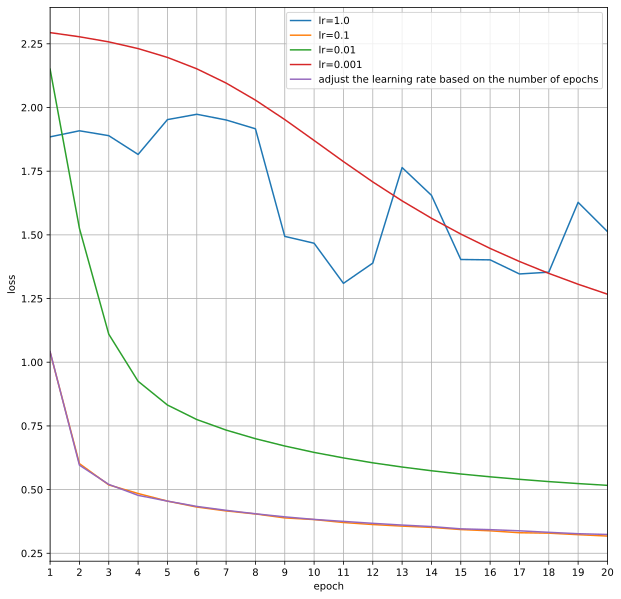

In [13]:
#import见4.2.1
listlr=[1.0,0.1,0.01,0.001]
train_iter, test_iter = d2l.load_data_fashion_mnist(256, resize=None)
num_epochs=20
d2l.plt.figure(figsize=(10, 10))
for lr in listlr:
    num_inputs=784; num_outputs=10; num_hiddens = 256;
    W1,b1,W2,b2, params=initweight4_2_1()#initweight4_2_1定义见4.2.1
    updater = torch.optim.SGD(params, lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    epoch_loss=[]
    def relu(X):
        a = torch.zeros_like(X)
        return torch.max(X, a)
    def net(X):
        X = X.reshape((-1, num_inputs))
        H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
        return (H@W2 + b2)
    
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        
        
        epoch_loss.append(train_metrics[0])
    train_loss, train_acc = train_metrics
    d2l.plt.plot(range(1,num_epochs+1), epoch_loss,label= (f'lr={lr}') )
    
# 补充 关于学习率的动态调整算法，可参考pytorch官方文档：https://pytorch.org/docs/stable/optim.html
# 下面以指数衰减策略为例调整学习率
num_inputs=784; num_outputs=10; num_hiddens = 256;
W1,b1,W2,b2, params=initweight4_2_1()#initweight4_2_1定义见4.2.1
loss = nn.CrossEntropyLoss(reduction='none')
'***************************************************************************'
optimizer_ExpLR = torch.optim.SGD(params, lr=0.1) # 定义一个优化器，初始学习率为0.1
scheduler_ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer_ExpLR, gamma=0.99) # 定义指数衰减学习率调度器，根据给定的衰减率 gamma 对优化器的学习率进行指数衰减
'***************************************************************************'
epoch_loss=[]
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

for epoch in range(num_epochs):
    '**************************************************************************'
    train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, optimizer_ExpLR)
    scheduler_ExpLR.step()
    '**************************************************************************'
    test_acc = d2l.evaluate_accuracy(net, test_iter)
    
    epoch_loss.append(train_metrics[0])
train_loss, train_acc = train_metrics
d2l.plt.plot(range(1,num_epochs+1), epoch_loss,label= 'adjust the learning rate based on the number of epochs' )


d2l.plt.xlim(1,num_epochs)
d2l.plt.xticks(list(range(1,num_epochs+1)))
d2l.plt.xlabel('epoch')
d2l.plt.ylabel('loss')
d2l.plt.grid();
d2l.plt.legend();
d2l.plt.show();

### 练习4.2.4

通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？

**解答：** 

&emsp;&emsp;考虑隐藏层数固定为1,学习轮数固定为10,每层的隐藏单元数在（256，128，64 ,32,16）中选取，学习率在（0.0001,0.001,0.01,0.1,1)范围内选取，batch_size(批大小)在（512,256,128,64,32,16）范围内选取的超参数优化。以下展示部分实验数据(由于训练的随机性后面展示的结果得到的数据与此表格会有一些不相符）


| num_epochs | batch_size |  lr  | num_hiddens | test_acc | train_acc | train_loss  |
| ---------- | ---------- | :--: | ----------- | -------- | --------- | ----------- |
| 10         | 256        | 0.1  | 32          | 0.8459   | 0.854367  | 0.41196403  |
| 10         | 128        | 0.1  | 256         | 0.8629   | 0.8808833 | 0.33219405  |
| 10         | 64         | 0.1  | 256         | 0.8769   | 0.89346   | 0.291003041 |
| 10         | 32         | 0.1  | 256         | 0.8865   | 0.9014    | 0.26649176  |
| 10         | 16         | 0.1  | 512         | 0.8824   | 0.90453   | 0.2544131   |




&emsp;&emsp;展示最优结果训练过程和数据

epochs=10,num_hiddens=256,lr=0.1,batch_size=32,train_loss=0.2674854329158862, train_acc=0.9014,test_acc=0.8798


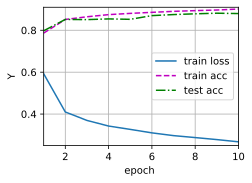

In [14]:
#import见4.2.1
num_inputs,num_outputs,num_hiddens=784,10,256
num_epochs, lr, batch_size = 10, 0.1,32
loss = nn.CrossEntropyLoss(reduction='none')
W1,b1,W2,b2, params=initweight4_2_1(num_inputs=num_inputs, num_outputs=num_outputs, num_hiddens=num_hiddens)#initweight4_2_1定义见4.2.1
updater = torch.optim.SGD(params, lr=lr)
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
animator = d2l.Animator(xlabel=f'epoch ',ylabel='Y', xlim=[1, num_epochs], ylim=[0.25, 0.91],
                legend=['train loss', 'train acc', 'test acc'])
for epoch in range(num_epochs):
    train_metrics = d2l.train_epoch_ch3(net, train_iter, loss,   updater)
    test_acc = d2l.evaluate_accuracy(net, test_iter)
        
    animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc
print(f'epochs={num_epochs},num_hiddens={num_hiddens},lr={lr},batch_size={batch_size},train_loss={train_loss}, train_acc={train_acc},test_acc={test_acc}')


&emsp;&emsp;考虑隐藏层数固定为2,并取第二层隐藏单元数为第一层隐藏单元数的一半和10两个数中较大的值，学习轮数固定为10,第一层的隐藏单元数在（256，128，64 ,32,16）中选取，学习率在（0.0001,0.001,0.01,0.1,1)范围内选取，batch_size(批大小)在（512,256,128,64,32,16）范围内选取的超参数优化。以下展示部分实验数据(由于训练的随机性后面展示的结果得到的数据与此表格会有一些不相符）


| num_epochs | batch_size |  lr  | num_hiddens1 | num_hiddens2 | test_acc | train_acc | train_loss |
| ---------- | ---------- | :--: | ------------ | ------------ | -------- | --------- | ---------- |
| 10         | 256        | 0.1  | 512          | 256          | 0.8854   | 0.90515   | 0.24805    |
| 10         | 128        | 0.1  | 256          | 128          | 0.8822   | 0.9017166 | 0.25835    |
| 10         | 64         | 0.1  | 512          | 256          | 0.8811   | 0.90435   | 0.248654   |
| 10         | 32         | 0.1  | 512          | 256          | 0.8837   | 0.906683  | 0.2463282  |
| 10         | 16         | 0.1  | 512          | 256          | 0.8789   | 0.90626   | 0.24752787 |

&emsp;&emsp;展示最优结果训练过程和数据

epochs=10,num_hiddens=512,num_hiddens2=256,lr=0.1,batch_size=256,train_loss=0.38594147764841713, train_acc=0.8609666666666667,test_acc=0.8405


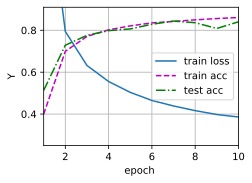

In [15]:
#import见4.2.1
def initweight4_2_4(num_inputs=784, num_outputs=10, num_hiddens = 256):
    num_hiddens2=int(num_hiddens/2) if (num_hiddens/2)>10 else 10
    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
    b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
    W2 = nn.Parameter(torch.randn(num_hiddens, num_hiddens2, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_hiddens2, requires_grad=True))
    W3 = nn.Parameter(torch.randn(num_hiddens2, num_outputs, requires_grad=True) * 0.01)
    b3 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params = [W1, b1, W2, b2,W3, b3]
    return W1,b1,W2,b2, W3, b3,params
num_inputs,num_outputs,num_hiddens=784,10,512
num_epochs, lr,batch_size = 10, 0.1,256
loss = nn.CrossEntropyLoss(reduction='none')
W1,b1,W2,b2,W3, b3, params=initweight4_2_4(num_inputs=num_inputs, num_outputs=num_outputs, num_hiddens=num_hiddens)
updater = torch.optim.SGD(params, lr=lr)
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)# 这里“@”代表矩阵乘法
    X2=H@W2 + b2
    H2 = relu(X2)
    return (H2@W3 + b3)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
animator = d2l.Animator(xlabel=f'epoch ',ylabel='Y', xlim=[1, num_epochs], ylim=[0.25, 0.91],
                legend=['train loss', 'train acc', 'test acc'])
for epoch in range(num_epochs):
    train_metrics = d2l.train_epoch_ch3(net, train_iter, loss,   updater)
    test_acc = d2l.evaluate_accuracy(net, test_iter)
        
    animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
assert train_loss < 0.5, train_loss
assert train_acc <= 1 and train_acc > 0.7, train_acc
assert test_acc <= 1 and test_acc > 0.7, test_acc
print(f'epochs={num_epochs},num_hiddens={num_hiddens},num_hiddens2={int(num_hiddens/2) if (num_hiddens/2)>10 else 10},lr={lr},batch_size={batch_size},train_loss={train_loss}, train_acc={train_acc},test_acc={test_acc}')

### 练习4.2.5

描述为什么涉及多个超参数更具挑战性。

**解答：**

 &emsp;&emsp;超参数无法通过常规的优化手段确定，每次调整超参数要依据训练结果导致调整一次需要的成本很大，而过多的超参数将导致更多的参数组合，使得通过训练来确定好最优的超参数很困难。

### 练习4.2.6

如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。

**解答：** 

 &emsp;&emsp;超参数无法通过常规的优化手段确定，每次调整超参数要依据训练结果导致调整一次需要的成本很大，而过多的超参数将导致更多的参数组合，使得通过训练来确定好最优的超参数很困难。根据过往的经验（文献或以前的实践）选定好一组超参数，从调整后计算成本最小的参数入手确定好它的值以后，再去确定计算成本比它大一点的参数，一步确定一个超参数，最后得到所有超参数的值，然后重复之前步骤，直到结果满意为止。

## 4.3 多层感知机的简洁实现

### 练习4.3.1

尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？

**解答：**

 &emsp;&emsp;考虑隐藏层数取512,256,128,64,32,16，以及0.0001,0.001,0.01,0.1,1,10取值范围的学习率，发现隐藏层数取256学习率取0.1效果最好。

&emsp;&emsp;以下使用torch编程进行实验：

 max batch_size:256,num_epochs:10,num_hiddens:256,lr:0.1,test_acc:0.8558,train_acc:0.86565,train_loss:0.37891749223073323


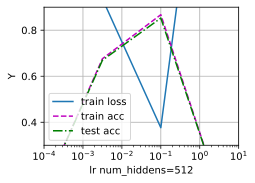

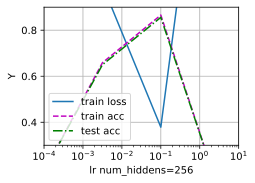

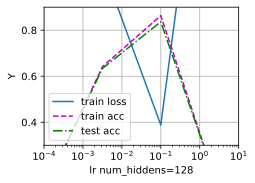

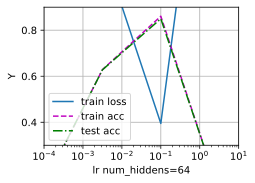

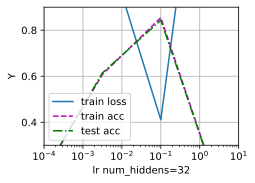

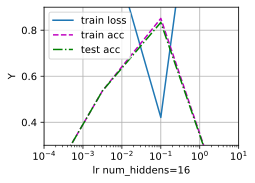

In [16]:
import torch
from d2l import torch as d2l
from torch import nn
import numpy as np
def init_weights4_3_1(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
def mytrain4_3_1(lr=0.1,num_hiddens=256,ac='ReLU',show=1,assertshow=1):
    #print(ac)
    net = nn.Sequential(nn.Flatten(),nn.Linear(784, num_hiddens))
    if ac=="Sigmoid":
        net.add_module('Sigmoid',nn.Sigmoid())
    elif ac=="Tanh":
        net.add_module('Tanh',nn.Tanh())
    else:
        net.add_module('ReLU',nn.ReLU())
    net.add_module('Linear',nn.Linear(num_hiddens, 10))             
    net.apply(init_weights4_3_1);
    batch_size,  num_epochs = 256, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    if show==1:
        animator = d2l.Animator(xlabel=f'epoch {ac} lr ={float(lr):f} num_hiddens={num_hiddens}',ylabel='Y', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss,  trainer)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        if show==1:
            animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    if assertshow==1:
        assert train_loss < 0.5, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc
    return train_loss,train_acc,test_acc
result=[]
for num_hiddens in [512,256,128,64,32,16]:
    animator2 = d2l.Animator(xlabel=f'lr num_hiddens={num_hiddens}', ylabel='Y',xlim=[1e-4,10], xscale='log',ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for lr in np.logspace(-4,2,5): # np.logspace(-4,2,5) 会生成一个包含 5 个元素的数组，这些元素是从 10^(-4) 到 10^2 的等比数列
        train_loss,train_acc,test_acc=mytrain4_3_1(lr=lr,num_hiddens=num_hiddens,show=0,assertshow=0)
        animator2.add(lr, (train_loss,train_acc,test_acc))
        result.append([num_hiddens, lr, test_acc,train_acc,train_loss])
resultmax=sorted(result, key=lambda x: x[2])[-1]
print(f' max batch_size:{256},num_epochs:{10},num_hiddens:{resultmax[0]},lr:{resultmax[1]},test_acc:{resultmax[2]},train_acc:{resultmax[3]},train_loss:{resultmax[4]}')

### 练习4.3.2

尝试不同的激活函数，哪个效果最好？

**解答：** 

&emsp;&emsp;$ReLU$效果最好，$Tanh$次之，$Sigmoid$最差训练损失最后超过了0.5。

Sigmoid train_loss: 0.5023181880315145


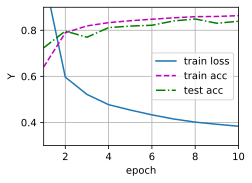

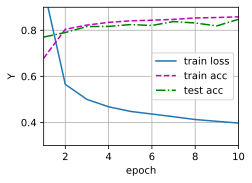

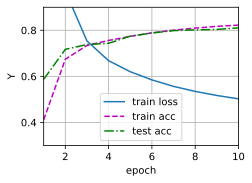

In [31]:
#import见4.3.1
def init_weights4_3_2(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
def train_diffactivation_function(ac):
    print(ac)
    net = nn.Sequential(nn.Flatten(),nn.Linear(784, 256))  # nn.Flatten() 用于将输入的多维数据压平成一维，nn.Linear(784, 256) 表示创建一个线性层，输入维度为 784，输出维度为 256
    if ac=="Sigmoid":
        net.add_module('Sigmoid',nn.Sigmoid())
    elif ac=="Tanh":
        net.add_module('Tanh',nn.Tanh())
    else:
        net.add_module('ReLU',nn.ReLU())
    net.add_module('Linear',nn.Linear(256, 10))             
    net.apply(init_weights4_3_2);
    batch_size, lr, num_epochs = 256, 0.1, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
    d2l.plt.ylabel("Y");

# 训练 ReLU 激活函数的网络
train_diffactivation_function(ac="ReLU")
# 训练 Tanh 激活函数的网络
train_diffactivation_function(ac="Tanh")
# 训练 Sigmoid 激活函数的网络
try:
    train_diffactivation_function(ac="Sigmoid")
except Exception as e:
    d2l.plt.ylabel("Y")
    print('Sigmoid train_loss:',e)

### 练习4.3.3

尝试不同的方案来初始化权重，什么方法效果最好？

**解答：** 

&emsp;&emsp;尝试了正态分布初始化权重，单位矩阵初始化权重，均匀分布初始化权重，在这个问题上单位矩阵初始权重的结果表现更好。

&emsp;&emsp;以下使用`torch`编程进行实验：

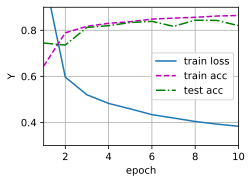

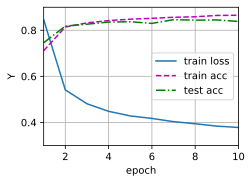

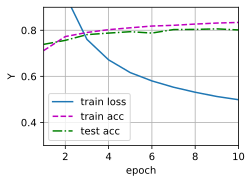

In [24]:
#import见4.3.1
def normal_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01) # 对参数 m.weight 进行均值为 0，标准差为 0.01 的正态分布初始化
            print("normal",m.weight)

def eye_weights(m):
       
        if type(m) == nn.Linear:
            nn.init.eye_(m.weight) # 对参数 m.weight 进行单位矩阵初始化
            print("eye",m.weight)

def uniform_weights(m):
       
        if type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-1,b=1) # 参数从均匀分布[-1, 1]进行初始化
            print("uniform",m.weight)
#可以选择权重初始化方式的训练函数 0 均匀分布初始化权重 1 单位矩阵初始化权重 2 均匀分布初始化权重
def train_diffweight(w):
    net = nn.Sequential(nn.Flatten(),nn.Linear(784, 256),nn.ReLU(),nn.Linear(256, 10))             
    if w==0:
        net.apply(normal_weights);
    elif w==1:
        net.apply(eye_weights);
    else:
        net.apply(uniform_weights);
    batch_size, lr, num_epochs = 256, 0.1, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
    d2l.plt.ylabel("Y")

    
train_diffweight(0)
train_diffweight(1)
train_diffweight(2)


## 4.4 模型选择、欠拟合和过拟合

### 练习4.4.1

这个多项式回归问题可以准确地解出吗？提示：使用线性代数。

**解答：** 

&emsp;&emsp;$$L(w)=\frac{1}{2} \sum_{i=1}^N\left(\sum_{j=0}^M w_j x_i^j-y_i\right)^2$$  

$$取 \frac{\partial L(w)}{\partial w_k}=0\Rightarrow\frac{1}{2} \sum_{i=1}^N 2\left(\sum_{j=0}^M w_j x_i^j-y_i\right) \times x_i^k=0 \Rightarrow \sum_{i=1}^N \sum_{j=0}^M w_j x_i^{j+k}=\sum_{i=1}^N x_i^k y_i(k=0,1,2, \cdots, M)\Rightarrow X W=Y$$

$$其中X=\left[\begin{array}{ccccc}
N & \sum_{i=1}^N x_i & \sum_{i=1}^N x_i^2 & \cdots & \sum_{i=1}^N x_i^M \\
\sum_{i=1}^M x_i & \sum_{i=1}^M x_i^2 & \sum_{i=1}^M x_i^3 & \cdots & \sum_{i=1}^M x_i^{N+1} \\
\sum_{i=1}^M x_i^2 & \sum_{i=1}^M x_i^3 & \sum_{i=1}^M x_i^4 & \cdots & \sum_{i=1}^M x_i^{N+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\sum_{i=1}^M x_i^N & \sum_{i=1}^M x_i^{N+1} & \sum_{i=1}^M x_i^{N+2} & \cdots & \sum_{i=1}^M x_i^{2 N}
\end{array}\right], \quad W=\left[\begin{array}{c}
w_0 \\
w_1 \\
w_2 \\
\vdots \\
w_M
\end{array}\right], \quad Y=\left[\begin{array}{c}
\sum_{i=1}^N y_i \\
\sum_{i=1}^N\left(x_i^2 y_i\right) \\
\vdots \\
\sum_{i=1}^N\left(x_i^N y_i\right)
\end{array}\right]
$$

$$ W=X^{-1} Y$$

### 练习4.4.2

考虑多项式的模型选择。
1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
2. 在这种情况下绘制测试的损失图。
3. 生成同样的图，作为数据量的函数。

**解答：** 

&emsp;&emsp;
1.在多项式阶数没有达到4之前阶数增加使得训练损失下降 当阶数超过4时训练损失几乎不变稳定在0.01这个数量级

&emsp;&emsp;
2. 绘制测试的损失图。

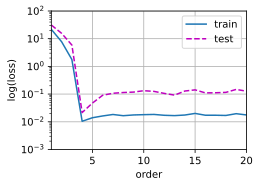

In [22]:
import math
import torch
from d2l import torch as d2l
from torch import nn
import numpy as np

n_train, n_test = 100, 100  # 训练和测试数据集大小

def train4_4_2(orderlist,n_train, n_test,num_epochs=400,show=True):
    
    max_degree = 20  # 多项式的最大阶数
    true_w = np.zeros(max_degree)  # 分配大量的空间
    true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

    features = np.random.normal(size=(n_train + n_test, 1))
    np.random.shuffle(features)
    poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)! 缩小高幂次的特征
    # labels的维度:(n_train+n_test,)
    labels = np.dot(poly_features, true_w)
    labels += np.random.normal(scale=0.1, size=labels.shape)#加上随机噪声
    true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
    if show==True:
        animator = d2l.Animator(xlabel='order', ylabel='log(loss)', yscale='log',
                                xlim=[1, orderlist[-1]], ylim=[1e-3, 1e2],
                                legend=['train', 'test'])
       
    train_losslist,test_losslist=[],[]
    for i in orderlist:
        train_features, test_features, train_labels, test_labels=poly_features[:n_train, :i],poly_features[n_test:, :i],labels[:n_train], labels[n_test:]
        loss = nn.MSELoss(reduction='none')
        input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
        net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
        batch_size = min(10, train_labels.shape[0])#最大batch_size设为10
        train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
        test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)
        trainer = torch.optim.SGD(net.parameters(), lr=0.01)
        for epoch in range(num_epochs):
            d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        train_loss=d2l.evaluate_loss(net, train_iter, loss)
        test_loss=d2l.evaluate_loss(net, test_iter, loss)
        train_losslist.append(train_loss)
        test_losslist.append(test_loss)
        if show==True:
            animator.add(i, (train_loss,test_loss))
            
    return train_losslist,test_losslist
   
train4_4_2(np.arange(1,21),n_train, n_test,400);

&emsp;&emsp;
3. 生成同样的图，作为数据量的函数。

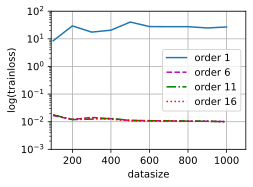

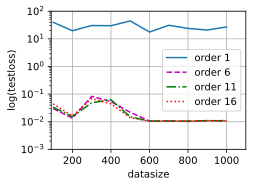

In [23]:
animator = d2l.Animator(xlabel='datasize', ylabel='log(trainloss)', yscale='log',
                                xlim=[90, 1100], ylim=[1e-3, 1e2],
                                legend=list(map(lambda x: "order {}".format(x),np.arange(1,21,5))))
animator2 = d2l.Animator(xlabel='datasize', ylabel='log(testloss)', yscale='log',
                                xlim=[90, 1100], ylim=[1e-3, 1e2],
                                legend=list(map(lambda x: "order {}".format(x),np.arange(1,21,5))))
for datasize in range(100,1100,100):
    train_losslist,test_losslist=train4_4_2(np.arange(1,21,5),datasize, datasize,num_epochs=400,show=False)
    animator.add(datasize, list(train_losslist))
    animator2.add(datasize, list(test_losslist))

### 练习4.4.3

如果不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？能用其他方法解决这个问题吗？

**解答：** 

&emsp;&emsp;避免出现较大的梯度值或者损失值。除了这个办法我们也可以让每个特征减去该特征数据的平均值并除于标准差。

### 练习4.4.4

泛化误差可能为零吗？

**解答：**  

&emsp;&emsp;在训练数据足够多的时候泛化误差接近经验误差，实验对于确定可解，且数据没有噪声的问题泛化误差可以为零。

## 4.5 权重衰减

### 练习4.5.1

在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数图。可以观察到什么？

**解答：** 

&emsp;&emsp;随着$\lambda$增加训练精度和测试进度逐渐靠近，但最终没有靠到一起。

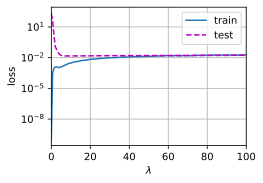

In [25]:
import torch
from d2l import torch as d2l
from torch import nn

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
net = nn.Sequential(nn.Linear(num_inputs, 1))
loss = nn.MSELoss(reduction='none')
def train_wd(wdlist,net,loss,train_data,test_iter,layer=[0],num_epochs=100,lr=0.003):
    
    animator = d2l.Animator(xlabel='$\lambda$', ylabel='loss', yscale='log',
                            xlim=[wdlist[0],wdlist[-1]], legend=['train', 'test'])
    for param in net.parameters():
        param.data.normal_()
    
    
    # 偏置参数没有衰减
    for wd in wdlist:
        for i in layer:
            trainer = torch.optim.SGD([
                {"params":net[i].weight,'weight_decay': wd},
                {"params":net[i].bias}], lr=lr)
   
        for epoch in range(num_epochs):
            for X, y in train_iter:
                trainer.zero_grad()
                l = loss(net(X), y)
                l.mean().backward()
                trainer.step()
            
        animator.add(wd,(d2l.evaluate_loss(net, train_iter, loss),
                              d2l.evaluate_loss(net, test_iter, loss)))
train_wd(np.linspace(0.,100.,150),net,loss,train_iter,test_iter)      

### 练习4.5.2

使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？

**解答：** 

&emsp;&emsp;不一定是最优的解，但绝对不是过拟合的解。

### 练习4.5.3

如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？

**解答：**

&emsp;&emsp;$$L(\mathbf{w}, b)+\lambda\|\mathbf{w}\|_1$$


$$\mathbf{w} \leftarrow \mathbf{w}-\eta \lambda sign(\mathbf{w})-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)$$

### 练习4.5.4

我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。能找到类似的矩阵方程吗？（见2.3.10节中的佛罗贝尼乌斯范数）

**解答：** 

&emsp;&emsp;$$\|\mathbf{w}\|_2= \left[\mathbf{w}^\top \mathbf{w}\right]^{1 / 2}$$

### 练习4.5.5

回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合？

**解答：**

 &emsp;&emsp;可以在验证误差下降到最低点的时候停止训练，防止过拟合。

### 练习4.5.6

在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？

**解答：** 

&emsp;&emsp;如果考虑最大后验估计（MAP）$$ w=\underset{w}{\arg \max } P(w \mid x)=\underset{w}{\arg \max }(P(x \mid w) P(w))=\underset{w}{\arg \max }log(P(x \mid w) P(w))=\underset{w}{\arg \max }log(P(x \mid w) +log(P(w))$$
&emsp;&emsp;如果考虑$P(w)$为正态分布 


$$
\begin{gathered}
w_i \sim N\left(0, \sigma^2\right) \\
\log P(w)=\log \prod_i \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{\left(w_i-0\right)^2}{2 \sigma^2}} \\
=-\frac{1}{2 \sigma^2} \sum_i w_i^2+C
\end{gathered}
$$
&emsp;&emsp;将得到$L_2$正则化的结果,如果考虑$P(w)$为拉普拉斯分布


$$
\begin{aligned}
w_i & \sim \operatorname{Laplace}(0, b) \\
\log P(w) & =\log \prod_i \frac{1}{2 b} e^{-\frac{\left|w_i-0\right|}{b}} \\
& =-\frac{1}{b} \sum_i\left|w_i\right|+C
\end{aligned}
$$
&emsp;&emsp;将得到$L_1$正则化的结果

## 4.6 暂退法

### 练习4.6.1

如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

**解答：** 

&emsp;&emsp;交换两层的暂退法概率会导致结果变差。提高暂退法概率也会使得loss更大，训练预测的准确度下降，同时调整第一层暂退法概率带来的影响比第二层的大。

In [26]:
import torch
from d2l import torch as d2l
from torch import nn
import numpy as np
#修改Animator定义 用来画多行多列的图
class myAnimator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5),wspace=0.5, hspace =0.8):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        
        self.config_axes =lambda axesnx,axesny: d2l.set_axes(self.axes[axesnx,axesny], xlabel, ylabel, xlim, ylim, xscale, yscale, legend) if axesnx==0&axesny==0 else d2l.set_axes(self.axes[axesnx,axesny], xlabel, ylabel, xlim, ylim, xscale, yscale,[])
                    
        d2l.plt.subplots_adjust(wspace =wspace, hspace =hspace)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self,axesnx,axesny, x, y,title=None):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[axesnx,axesny].cla()
        if title:
            self.axes[axesnx,axesny].set_title(title)
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[axesnx,axesny].plot(x, y, fmt)
        self.config_axes(axesnx,axesny)
        d2l.display.display(self.fig)
        d2l.display.clear_output(wait=True)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
def Net(dropout1=0.5,dropout2=0.2,num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=256):
    net = nn.Sequential(nn.Flatten(),
                nn.Linear(num_inputs, num_hiddens1),
                nn.ReLU(),
                nn.Dropout(dropout1),
                nn.Linear(num_hiddens1, num_hiddens2),
                nn.ReLU(),
                nn.Dropout(dropout2),
                nn.Linear(num_hiddens2, num_outputs))
    return net

def changedropout(dropout1list=[0.5], dropout2list=[0.2], num_epochs=10, lr=0.5,batch_size=256,
                  num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=256,wd=None,figsize=(15, 10),
                  wspace=0.2, hspace =0.3,xlim=[1, 10], ylim=[0.3, 0.9],show=True):
    ndropout1,ndropout2=len(dropout1list),len(dropout2list)#计算要画几行几列的图
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    if show==True:
        if (ndropout1==1)&(ndropout2==1):
                animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=xlim, ylim=ylim,
                                legend=['train loss', 'train acc', 'test acc'],figsize=figsize)
        else:
                animator = myAnimator(xlabel='epoch',ylabel='Y', xlim=[1,num_epochs], ylim=ylim,
                                legend=['train loss', 'train acc', 'test acc'],nrows=ndropout1, ncols=ndropout2,figsize=figsize,wspace=wspace, hspace =hspace)
    
    train_losslist, train_acclist,test_acclist=np.zeros(( ndropout1,ndropout2,num_epochs)),np.zeros((ndropout1,ndropout2,num_epochs)),np.zeros((ndropout1,ndropout2,num_epochs))
    for i in range(ndropout1):
        for j in range(ndropout2):
            dropout1,dropout2=dropout1list[i],dropout2list[j]
            net = Net(dropout1,dropout2)
            net.apply(init_weights);
            loss = nn.CrossEntropyLoss(reduction='none')
            if wd==None:
                trainer=torch.optim.SGD(net.parameters(),lr=lr)
            else:
                paramslist=[]
                for m in net:
                        if type(m) == nn.Linear:
                            paramslist.append({"params": m.weight,'weight_decay': wd})
                            paramslist.append({"params":m.bias})
                trainer=torch.optim.SGD(paramslist,lr=lr)#设置权重衰减
            
            for epoch in range(num_epochs):
                train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
                test_acc = d2l.evaluate_accuracy(net, test_iter)
                train_losslist[i,j,epoch],train_acclist[i,j,epoch],test_acclist[i,j,epoch]=train_metrics[0],train_metrics[1],test_acc
                if show==True:
                    if ndropout1==1&ndropout2==1:
                        animator.add(epoch + 1, train_metrics + (test_acc,))
                    else:
                        animator.add(i,j,epoch + 1, train_metrics + (test_acc,),title=f"dropout1:{dropout1},dropout2:{dropout2}")
            #animator.axes[i,j].set_title(f"dropout1:{dropout1},dropout2:{dropout2}")    
            if show==True:
                animator.X,animator.Y=None, None
                
            train_loss, train_acc = train_metrics
            #实验中不能保证loss较低所以不使用后面这段代码
#            assert train_loss < 0.5, train_loss
#            assert train_acc <= 1 and train_acc > 0.7, train_acc
#            assert test_acc <= 1 and test_acc > 0.7, test_acc
    return  train_losslist,train_acclist,test_acclist

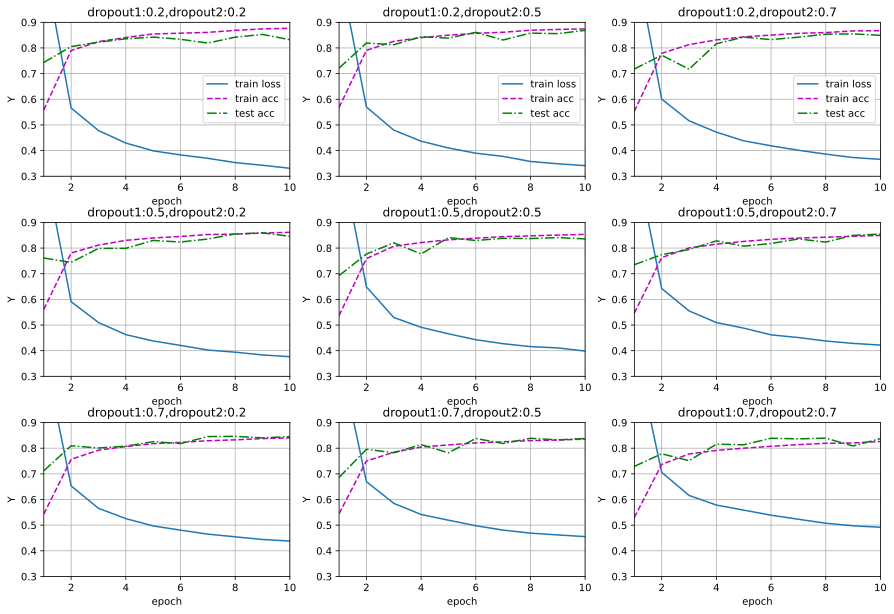

In [27]:
dropout1list,dropout2list=[0.2,0.5,0.7],[0.2,0.5,0.7]
train_losslist,train_acclist,test_acclist=changedropout(dropout1list=[0.2,0.5,0.7],dropout2list=[0.2,0.5,0.7])

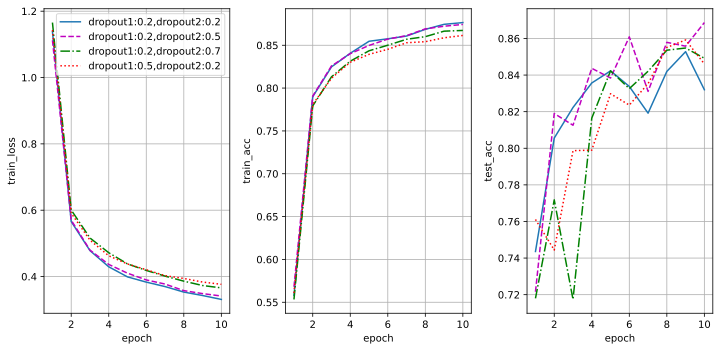

In [28]:
d2l.plt.figure(figsize=(12, 5.5))
d2l.plt.subplot(131)
d2l.plot(list(range(1,11)),np.vstack([train_losslist[i,:,:] for i in range(3)]),'epoch', 'train_loss',
                     legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list])
d2l.plt.subplot(132)
d2l.plot(list(range(1,11)),np.vstack([train_acclist[i,:,:] for i in range(3)]),'epoch', 'train_acc')
                     #legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list],figsize=(10, 8))
d2l.plt.subplot(133)
d2l.plot(list(range(1,11)),np.vstack([test_acclist[i,:,:] for i in range(3)]),'epoch', 'test_acc')
                     #legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list],figsize=(10, 8))
d2l.plt.subplots_adjust(wspace =0.3, hspace =0)

### 练习4.6.2

增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

**解答：** 

 &emsp;&emsp;没使用dropout会出现loss值突然上升的情况（这可能使因为学习率设置过高），使用dropout的结果这种情况则会消失。

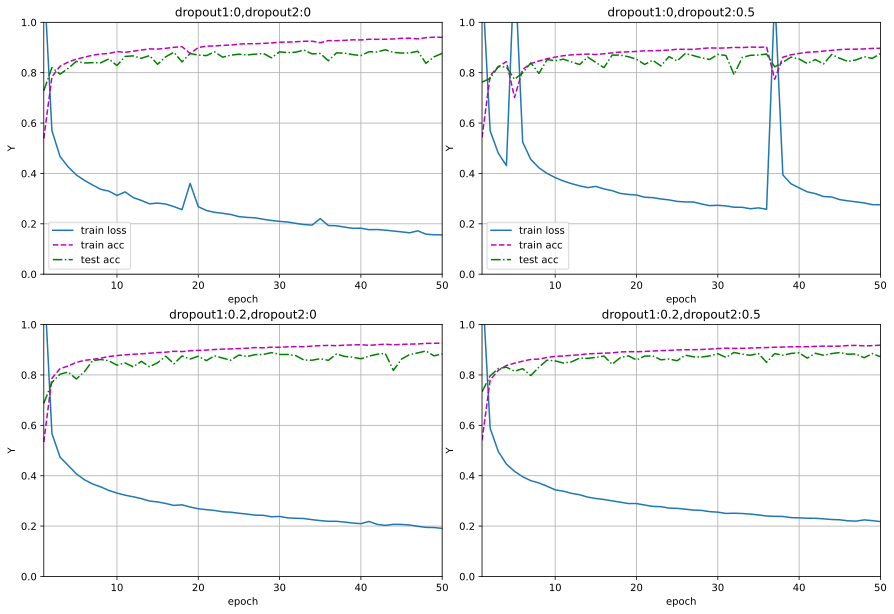

In [29]:
#import见4.6.1
num_epochs=50
dropout1list,dropout2list=[0,0.2],[0,0.5] 
train_losslist,train_acclist,test_acclist=changedropout(dropout1list=dropout1list,dropout2list=dropout2list,num_epochs=num_epochs,wspace=0.1, hspace =0.2,ylim=[0,1])

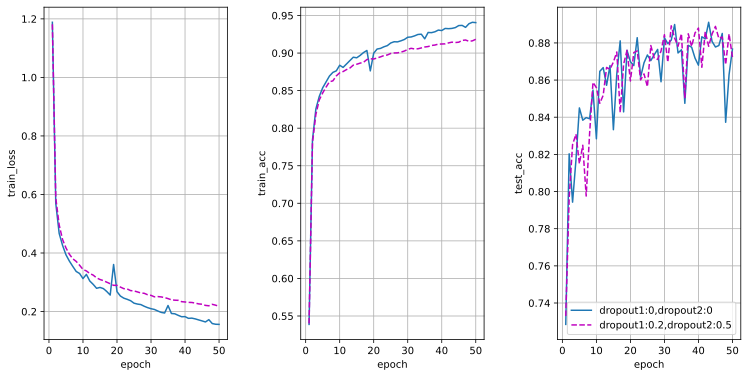

In [30]:
d2l.plt.figure(figsize=(12.5, 6)) 
d2l.plt.subplot(131)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((train_losslist[0,0,:],train_losslist[1,1,:])),'epoch', 'train_loss')
d2l.plt.subplot(132)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((train_acclist[0,0,:],train_acclist[1,1,:])),'epoch', 'train_acc')
d2l.plt.subplot(133)
d2l.plot(list(range(1,num_epochs+1)),np.vstack((test_acclist[0,0,:],test_acclist[1,1,:])),'epoch', 'test_acc',
                     legend=['dropout1:0,dropout2:0','dropout1:0.2,dropout2:0.5'])
d2l.plt.subplots_adjust(wspace =0.4, hspace =0)

### 练习4.6.3

当使用或不使用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。

**解答：**

&emsp;&emsp; 使用暂退法,每个中间活性值$h$以*暂退概率*$p$由随机变量$h'$替换,如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

&emsp;&emsp;其期望值保持不变，即$E[h'] = h$。它的方差 $D(h')=E\left((h'-E(h'))^2\right)=E\left(h'^2\right)-E^2\left(h'\right)=\displaystyle \frac{h^2}{\left(1-p\right)}-h$

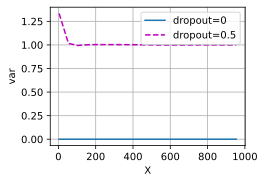

In [31]:
#import见4.6.1
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)
# X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
dropout0,dropout0d5,var_dropout0d5,var_dropout0=dropout_layer(torch.ones(1,dtype = torch.float32), 0),dropout_layer(torch.ones(1,dtype = torch.float32), 0.5),torch.empty(1),torch.empty(1)
#torch.var(dropout_layer(torch.ones(1,dtype = torch.float32), 0.5))
for _ in range(1000):
    dropout0d5=torch.cat([dropout0d5,dropout_layer(torch.ones(1,dtype = torch.float32), 0.5)])
    dropout0=torch.cat([dropout0,dropout_layer(torch.ones(1,dtype = torch.float32), 0)])
    
    var_dropout0d5=torch.cat([var_dropout0d5,torch.var(dropout0d5).reshape(1)])
    var_dropout0=torch.cat([var_dropout0,torch.var(dropout0).reshape(1)])

d2l.plot(torch.arange(2,1003)[2:-1:50], [var_dropout0.detach()[2:-1:50],var_dropout0d5.detach()[2:-1:50]],
         legend=['dropout=0','dropout=0.5'])
d2l.plt.xlabel("X");
d2l.plt.ylabel("var");

#, figsize=(4.5, 2.5)

### 练习4.6.4

为什么在测试时通常不使用暂退法？

**解答：** 

&emsp;&emsp;训练时使用暂退法是为了防止模型过拟合，提高网络泛化能力，而测试时我们希望可以用上所有的参数，减少参数反而会影响网络稳定性。

### 练习4.6.5

以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

**解答：** 

&emsp;&emsp;同时使用暂退法和权重衰减结果好于只使用使用暂退法或者权重衰减。暂退法和权重衰减使用不同的方式防止模型过拟合，同时使用用累加的效果。下表是某次实验的结果 由于训练存在随机性所以结果可能会不同

| method | $\lambda$ |  dropout1  | dropout2 | train loss | train_acc | test acc  |
| ---------- | ---------- | :--: | ----------- | -------- | --------- | ----------- |
| dropout       | \        | 0.2  | 0.5          |0.3475  |0.8727  | 0.8491   |
| dropout and weight decay        | 0.0001        | 0.2  | 0.5        |0.3523  | 0.8707   | 0.8538   |
|decay    |0.0001         | \ | \        | 0.3224   |  0.8797     |  0.8008 |


only dorpout train loss 0.3483 train acc 0.8723 test acc 0.8523 


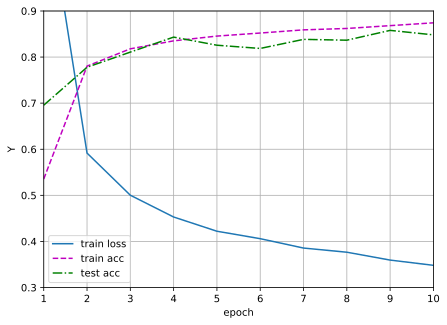

In [32]:
#import见4.6.1
#只用暂退法
train_loss1,train_acc1,test_acc1=0.,0.,0.
for i in range(10):
    show= False if i<9 else True
    train_losslist1,train_acclist1,test_acclist1=changedropout(dropout1list=[0.2],dropout2list=[0.5],figsize=(7, 5),show=show)
    train_loss1+=train_losslist1[-1][-1][-1]/10.0
    train_acc1+=train_acclist1[-1][-1][-1]/10.0
    test_acc1+=test_acclist1[-1][-1][-1]/10.0
print("only dorpout train loss {:.4f} train acc {:.4f} test acc {:.4f} ".format(train_loss1,train_acc1,test_acc1))

dorpout and weight decay  train loss 0.3518 train acc 0.8710 test acc 0.8498 


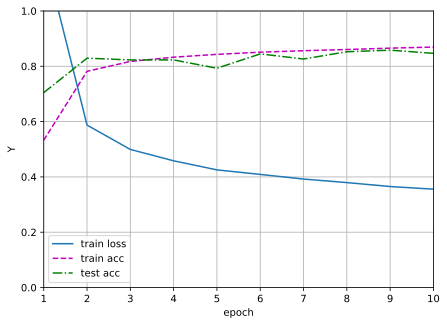

In [33]:
#暂退法加梯度衰减
train_loss2,train_acc2,test_acc2=0.,0.,0.
for i in range(10):
    show= False if i<9 else True
    train_losslist2,train_acclist2,test_acclist2=changedropout(dropout1list=[0.2],dropout2list=[0.5],wd=1e-4,ylim=[0,1],figsize=(7, 5),show=show)
    train_loss2+=train_losslist2[-1][-1][-1]/10.0
    train_acc2+=train_acclist2[-1][-1][-1]/10.0
    test_acc2+=test_acclist2[-1][-1][-1]/10.0
print("dorpout and weight decay  train loss {:.4f} train acc {:.4f} test acc {:.4f} ".format(train_loss2,train_acc2,test_acc2) )

weight decay  train loss 0.3223 train acc 0.8795 test acc 0.8507 


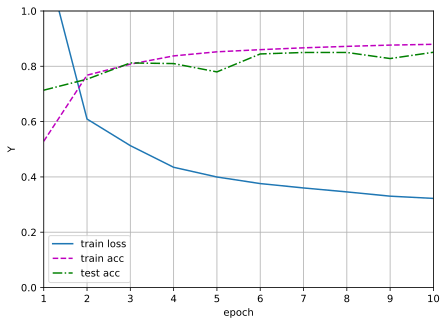

In [34]:
#import见4.6.1
#只有梯度衰减
train_losslist3,train_acclist3,test_acclist3=changedropout(dropout1list=[0],dropout2list=[0],wd=1e-4,ylim=[0,1],figsize=(7, 5))
print("weight decay  train loss {:.4f} train acc {:.4f} test acc {:.4f} ".format(train_losslist3[-1][-1][-1],train_acclist3[-1][-1][-1],test_acclist3[-1][-1][-1]) )

### 练习4.6.7

如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？

**解答：** 

&emsp;&emsp;考虑一个简单的单层没有偏置的神经网络，$\hat{y}=\phi(\mathbf{W} \mathbf{x}) $ ， $\hat{y}$是输出 ，$\phi$是激活函数,$\mathbf{W}$是权重，$\mathbf{x}$是输入.

&emsp;&emsp;定义dropout 为函数 
$$
D(h,p)=\begin{cases}0 & \text{ 概率为 } p \\\frac{h}{1-p} & \text{ 其他情况}\end{cases} 
$$   
&emsp;&emsp;有 
$$
\frac{\partial D(z,p) }{ \partial z}=\begin{cases}0 & \text{ 概率为 } p \\\frac{1}{1-p} & \text{ 其他情况}\end{cases}
$$
&emsp;&emsp;,取L为损失函数，$z=\mathbf{W} \mathbf{x}$,$z^\prime=D(\mathbf{W} \mathbf{x},p)$


&emsp;&emsp;考虑dropout 放在激活层后面

&emsp;&emsp;前向传播

$$
\hat{y}=D(\phi(\mathbf{W} \mathbf{x}),p)=\begin{cases}0 & \text{ 概率为 } p \\
\displaystyle\frac{\phi(\mathbf{W} \mathbf{x})}{1-p} & \text{ 其他情况}\end{cases} 
$$

&emsp;&emsp;反向传播

$$
\frac{\partial L }{ \partial\mathbf{W}}=\frac{\partial L }{ \partial \hat{y}} \frac{\partial D(\phi(z),p)}{ \partial \phi(z)}\frac{\partial \phi(z)}{ \partial z}\frac{\partial z}{ \partial \mathbf{w}}=\begin{cases}0 & \text{ 概率为 } p \\
\displaystyle\frac{\displaystyle\frac{\partial L }{ \partial \hat{y}} \frac{\partial \phi(z) }{ \partial z}\mathbf{x}}{1-p} & \text{ 其他情况}\end{cases}
$$

&emsp;&emsp;考虑dropout 放在激活层前面的情形

&emsp;&emsp;前向传播

$$
\hat{y}=\phi(D(\mathbf{W} \mathbf{x},p))=\begin{cases}\phi(0) & \text{ 概率为 } p \\\phi(\frac{\mathbf{W} \mathbf{x}}{1-p}) & \text{ 其他情况}\end{cases} 
$$

&emsp;&emsp;反向传播

$$
\frac{\partial L }{ \partial\mathbf{W}}=\frac{\partial L }{ \partial \hat{y}} \frac{\partial \phi(z^\prime)}{ \partial z^\prime}\frac{\partial D(\mathbf{z},p)}{ \partial z}\frac{\partial z}{ \partial \mathbf{w}}=\begin{cases}0 & \text{ 概率为 } p \\
\displaystyle\frac{\displaystyle\frac{\partial L }{ \partial \hat{y}} \frac{\partial \phi(z^\prime)}{ \partial z^\prime}\mathbf{x}}{1-p} & \text{ 其他情况}\end{cases}
$$


&emsp;&emsp;由于激活函数$\phi(0)$不一定为0所以dropout前置可能会使被置零的神经元在前向传播中还有会贡献值。

&emsp;&emsp;以下展示dropout前置结果

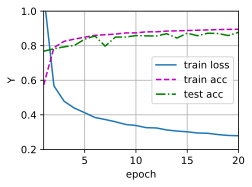

In [8]:
#import见4.6.1
# 定义训练相关参数
dropout1=0.2;dropout2=0.5;num_inputs=784; num_outputs=10; num_hiddens1=256; num_hiddens2=256;num_epochs=10;
#定义神经网络模型
net = nn.Sequential(nn.Flatten(),
                nn.Linear(num_inputs, num_hiddens1),
                nn.Dropout(dropout1),
                nn.ReLU(),
                nn.Linear(num_hiddens1, num_hiddens2),
                nn.Dropout(dropout2),
                nn.ReLU(),
                nn.Linear(num_hiddens2, num_outputs))
        
#加载数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
#绘图
animator = d2l.Animator(xlabel='epoch',ylabel='Y',xlim=[1,num_epochs], ylim=[0.2, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    
#初始化权重
net.apply(init_weights);
#定义交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')
#定义优化器
trainer = torch.optim.SGD(net.parameters(), lr=lr)
#训练            
for epoch in range(num_epochs):
    train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
    test_acc = d2l.evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
           
           
train_loss, train_acc = train_metrics

### 练习4.6.8

开发另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。

**解答：**

&emsp;&emsp;对每一个relu输出加上一个高斯噪声

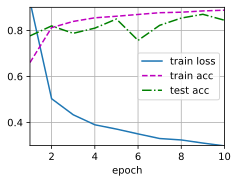

In [40]:
#import见4.6.1
# 定义带有噪声层的函数
def noise_layer(X,rate=0.1):
    return X+rate*torch.rand(X.shape) 
# 定义神经网络模型
class Net4_6_8(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net4_6_8, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用加入噪声
        if self.training == True:
            
            H1 = noise_layer(H1)
        H2 = self.relu(self.lin2(H1))
        # 只有在训练模型时才使用加入噪声
        if self.training == True:
            
            H2 = noise_layer(H2)
        out = self.lin3(H2)
        return out

# 设置模型参数    
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
# 创建神经网络模型
net = Net4_6_8(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
# 定义训练相关参数
num_epochs, lr, batch_size = 10, 0.5, 256
# 定义损失函数
loss = nn.CrossEntropyLoss(reduction='none')
# 加载Fashion-MNIST数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.7 前向传播、反向传播和计算图

### 练习4.7.1 

假设一些标量函数$f$的输入$\mathbf{X}$是$n \times m$矩阵。$f$相对于$\mathbf{X}$的梯度维数是多少？

**解答：** 

&emsp;&emsp;根据梯度的定义，标量函数$\mathbf{f}$相较于$n \times m$实矩阵$\mathbf{X}$的梯度为$n \times m$矩阵，简称为梯度矩阵

$$\nabla_{\mathrm{X}} f(\mathrm{X})=\left[\begin{array}{cccc}\frac{\partial f(\mathrm{X})}{\partial \mathrm{x}_{11}} & \frac{\partial f(\mathrm{X})}{\partial \mathrm{x}_{12}} & \cdots & \frac{\partial f(\mathrm{X})}{\partial x_{1 m}} \\ \frac{\partial f(\mathrm{X})}{\partial x_{21}} & \frac{\partial f(\mathrm{X})}{\partial x_{22}} & \cdots & \frac{\partial f(\mathrm{X})}{\partial x_{2 m}} \\ \vdots & \vdots & \ddots & \vdots \\ \frac{\partial f(\mathrm{X})}{\partial x_{n 1}} & \frac{\partial f(\mathrm{X})}{\partial x_{n 2}} & \cdots & \frac{\partial f(\mathrm{X})}{\partial x_{n m}}\end{array}\right]=\frac{\partial f(\mathrm{X})}{\partial \mathrm{X}}$$

&emsp;&emsp;所以答案为$n \times m$ 维

### 练习4.7.2

向本节中描述的模型的隐藏层添加偏置项（不需要在正则化项中包含偏置项）。

1. 画出相应的计算图。
2. 推导正向和反向传播方程。

**解答：**

&emsp;&emsp;
1. ![计算图](../../images/ch04-7-2-Computational-Graph-of-Forward-Propagation.png)


&emsp;&emsp;
2. 正向传播方程 只要我们沿着计算图逐项计算就可以得到

$$
\mathbf{z^\prime}=\mathbf{W}^{(1)} \mathbf{x},\mathbf{z}=\mathbf{b}^{(1)}+ \mathbf{z^\prime},\mathbf{h}=\mathbf{\phi} (\mathbf{z}),\mathbf{o^\prime}=\mathbf{W}^{(2)} \mathbf{h},\mathbf{o}=\mathbf{b}^{(2)}+ \mathbf{o^\prime},L=l(\mathbf{o}, y),s=\frac{\lambda}{2}\left(\left\|\mathbf{W}^{(1)}\right\|_F^2+\left\|\mathbf{W}^{(2)}\right\|_F^2\right),J=L+s
$$


&emsp;&emsp;&emsp;&emsp;反向传播方程

&emsp;&emsp;&emsp;&emsp;反向传播的目的是计算梯度$\displaystyle\frac{\partial J}{\partial \mathbf{W}^{(1)}} \text { , }\displaystyle \frac{\partial J}{\partial \mathbf{W}^{(2)}}\text{,} \displaystyle\frac{\partial J}{\partial \mathbf{b}^{(1)}} \text { , }\displaystyle \frac{\partial J}{\partial \mathbf{b}^{(2)}}$

&emsp;&emsp;&emsp;&emsp;前两个式子和本章文中相同
$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

$$
\frac{\partial J}{\partial \mathbf{W}^{(2)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)
= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.
$$
&emsp;&emsp;&emsp;&emsp;可以参考教材4.7.3

>第一步是计算目标函数$J=L+s$相对于损失项$L$和正则项$s$的梯度。
>
>$$\frac{\partial J}{\partial L} = 1 \; \text{and} \; \frac{\partial J}{\partial s} = 1.$$
>
>接下来，我们根据链式法则计算目标函数关于输出层变量$\mathbf{o}$的梯度：
>
>$$
\frac{\partial J}{\partial \mathbf{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$
>
>接下来，我们计算正则化项相对于两个参数的梯度：
>
>$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \text{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$
>
>现在我们可以计算最接近输出层的模型参数的梯度
>$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$。
>使用链式法则得出：
>
>$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
>
>为了获得关于$\mathbf{W}^{(1)}$的梯度，我们需要继续沿着输出层到隐藏层反向传播。
>关于隐藏层输出的梯度$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$由下式给出：
>
>$$
\frac{\partial J}{\partial \mathbf{h}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$
>
>由于激活函数$\phi$是按元素计算的，
>计算中间变量$\mathbf{z}$的梯度$\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
>需要使用按元素乘法运算符，我们用$\odot$表示：
>
>$$
\frac{\partial J}{\partial \mathbf{z}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$
>
>最后，我们可以得到最接近输入层的模型参数的梯度
>$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$。
>根据链式法则，我们得到：
>
>$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

&emsp;&emsp;&emsp;&emsp;根据链式子法则，后面两个式子的结果为：
$$
\frac{\partial J}{\partial \mathbf{b}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{b}^{(2)}}\right) 
= \frac{\partial J}{\partial \mathbf{h}}.
$$

$$
\frac{\partial J}{\partial \mathbf{b}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{b}^{(2)}}\right) 
= \frac{\partial J}{\partial \mathbf{o}}.
$$


### 练习4.7.3

计算本节所描述的模型，用于训练和预测的内存空间。

**解答：**

&emsp;&emsp;训练需要存储的参数：$x,z,h,o,y,W^{(1)},W^{(2)}, \displaystyle\frac{\partial J}{\partial \mathbf{W}^{(1)}} ，\displaystyle \frac{\partial J}{\partial \mathbf{W}^{(2)}}$

&emsp;&emsp;假设输入数据为n维$W^{(1)}$和$\displaystyle\frac{\partial J}{\partial \mathbf{W}^{(1)}}$为$𝑛×𝑚$维,则$z$和$h$为$m$维。$W^{(2)}$和$\displaystyle\frac{\partial J}{\partial \mathbf{W}^{(2)}}$为$m×k$维,则$o$和有为$k$维 。 网络参数为浮点小数，通常用float单精度表示，单精度float占32位/4个字节。那么占用总字节数为$(n+n×m×2+2×m+m×k×2+k×2)×4B$

&emsp;&emsp;预测需要存储的参数：$x,z,h,o,y,W^{(1)},W^{(2)}$可以估计出占用内存总字节数为$(n+n×m+2×m+m×k+k×2)×4B$

### 练习4.7.4

假设想计算二阶导数。计算图发生了什么？预计计算需要多长时间？

**解答：**

&emsp;&emsp; 需要在构造一个以一阶导数为正向传播的计算图，然后再反向传播求导。可能会花费相对与计算一阶导数时两倍的时间。

### 练习4.7.5

假设计算图对当前拥有的GPU来说太大了。

1. 请试着把它划分到多个GPU上。
2. 与小批量训练相比，有哪些优点和缺点？

**解答：**

 1. 我们可以把网络按三种方式把它划分到GPU上,网络并行、分层并行、数据并行。网络并行把每层网络的计算划分到不同的GPU。分层并行把每层内的计算划分到不同的GPU,比如把全连接层输出单元拆分到不同gpu上计算。数据并行把数据拆分分别在不同gpu上计算同样的网络然后汇总各个gpu上更新参数。
 2. 优点是多个GPU集群可以训练较大的模型（前两种划分方法可以）以及更快的训练模型（第三种划分），但是缺点是可能会因为节点间通信的限制导致速度不够快。

## 4.8 数值稳定性和模型初始化

### 练习4.8.1

除了多层感知机的排列对称性之外，还能设计出其他神经网络可能会表现出对称性且需要被打破的情况吗？

**解答：** 

&emsp;&emsp;卷积神经网络卷积层的多个输出通道具有对称性，需要在初始化时保证他们不是相同值。

### 练习4.8.2

我们是否可以将线性回归或`softmax`回归中的所有权重参数初始化为相同的值？

**解答：**

 &emsp;&emsp;当所有权重参数具有相同的初始值时，模型在进行反向传播和参数更新时，每个权重都会以相同的方式更新。这种情况下，每个特征在模型中的作用是相同的，无法体现特征之间的差异和重要性。这可能导致模型的学习能力受限，难以捕捉到数据中的复杂关系。

&emsp;&emsp;相反，使用不同的初始值可以帮助模型在训练过程中探索不同的权重组合，以更好地适应数据。常用的初始化方法包括随机初始化（如从均匀分布或正态分布中随机采样）和Xavier初始化（根据输入和输出维度自适应地选择合适的初始范围）。

&emsp;&emsp;因此，为了有效地训练线性回归或`softmax`回归模型，通常建议对权重参数进行适当的初始化，以便在训练过程中提供足够的表达能力和灵活性。

### 练习4.8.3

在相关资料中查找两个矩阵乘积特征值的解析界。这对确保梯度条件合适有什么启示？

**解答：** 

&emsp;&emsp;$\boldsymbol{A}, \boldsymbol{B}$ 为 $n$ 阶实对称不定矩阵 $\boldsymbol{A B}=\boldsymbol{B A}$, 矩阵 $\boldsymbol{A}$ 的 $n$ 个特征值为 $\lambda_1 \leqslant \lambda_2 \leqslant \cdots$ $\leqslant \lambda_n$, 矩阵 $\boldsymbol{B}$ 的 $n$ 个特征值为 $\mu_1 \leqslant \mu_2 \leqslant \cdots \leqslant \mu_n$ 则矩阵 $\boldsymbol{A B}$ 的特征值 $\min \left\{\lambda_1 \mu_n, \lambda_n \mu_1\right\} \leqslant \lambda \leqslant$ $\max \left\{\lambda_1 \mu_1, \lambda_n \mu_n\right\}$ 。当考虑梯度爆炸问题时我们应该爆炸计算梯度的矩阵最大特征值尽量小，当考虑梯度消失问题时计算梯度矩阵最小特征值尽量大。


### 练习4.8.4

如果我们知道某些项是发散的，我们能在事后修正吗？可以参考关于按层自适应速率缩放的论文[190]。

**解答：**

 &emsp;&emsp;原问题应该是我们知道模型的某一层会发散，我们能事后修正吗？
 我们可以通过计算每层权重的范数和梯度范数的比值来衡量训练稳定性并以此为依据调节每一层的学习率，如下式所示：
$$ \lambda^l=\eta \times \frac{\left\|w^l\right\|}{\left\|\nabla L\left(w^l\right)\right\|}$$
&emsp;&emsp;$l$表示第几层网络 $L$表示损失函数 $\eta$表示你对用权重的范数和梯度范数的比值来衡量学习率的信任程度。

## 4.9 环境和分布偏移

### 练习4.9.1

当我们改变搜索引擎的行为时会发生什么？用户可能会做什么？广告商呢？

**解答：**

 &emsp;&emsp;当改变搜索引擎的行为时，可能会发生以下情况：

1. 用户的反应：用户可能会对搜索引擎行为的改变做出不同的反应。一些用户可能会适应并接受这些变化，继续使用搜索引擎进行他们的查询。其他用户可能会感到不满意或困惑，因为他们习惯了特定的搜索结果和功能。这可能导致他们寻找替代的搜索引擎或采取其他方式来获取所需信息。

2. 用户行为的变化：如果搜索引擎的行为发生显著变化，用户可能会调整他们的搜索策略。他们可能会更改搜索关键词的选择、尝试不同的搜索策略或使用高级搜索选项来获得更精确的结果。一些用户可能会更多地依赖其他信息来源，如社交媒体、专业网站或应用程序。

3. 广告商的反应：搜索引擎行为的改变可能会对广告商产生影响。广告商通常依赖搜索引擎为他们的广告投放提供曝光和流量。如果搜索引擎的行为发生变化，广告商可能需要重新评估他们的广告策略和投放方式，以确保他们的广告仍然能够有效地触达目标受众。

4. 广告排名和竞争：搜索引擎行为的改变可能会对广告排名和竞争产生影响。如果搜索引擎调整了广告排名算法或显示广告的方式，广告商可能需要重新评估他们的广告优化策略和预算分配，以适应这些变化。竞争激烈的行业可能会看到广告竞价的变化和竞争格局的调整。

&emsp;&emsp;需要注意的是，具体情况会根据搜索引擎的改变方式、用户群体和广告市场的特点而有所不同。搜索引擎的行为改变可能是出于改善搜索结果质量、提供更相关的信息或应对不断变化的用户需求等目的。

### 练习4.9.2

实现一个协变量偏移检测器。提示：构建一个分类器。

**解答：**

 &emsp;&emsp;为了构造协变量偏移的场景我们使用[kaggle的dogvscat训练数据集](https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip)选取一部分动漫化处理(处理方法见这个[github地址](https://github.com/bryandlee/animegan2-pytorch)),然后构成一个cartoonvsnormal数据集（数据集 百度网盘链接: 链接: https://pan.baidu.com/s/1FvWaa3MBxQXLEmOLZTm6uw?pwd=1234 提取码: 1234 存放在../data/下），用已经预训练好的resnet50模型加一个全连接层(这部分会在后面的章节学到，你可以把这部分认为是本章提到的exp(h(x))的h函数)来实现分类器的效果。  
 resnet50参考：https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

 &emsp;&emsp;要分类的数据集（不过值得一提的是我找到的卡通化方法不是非常有效,一些图片没有很好实现卡通化的效果，不过还是足够做为协变量偏移的例子来学习）
![](../data/ch04-4-9-2and4-9-3.png)

In [1]:
import torch 
import torchvision
from torchvision import datasets,models,transforms
import os
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from d2l import torch as d2l
import gc 
import random
gc.collect()#清理内存
#计算数据标准差和平均值的函数
def getmean_str(data_dir,name):
    data_trainsforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])#对图片进行一些变化操作
    #构建图片数据集
    image_datasets = datasets.ImageFolder(root=data_dir,
                          transform=data_trainsforms)
    data_loader = torch.utils.data.DataLoader(
        image_datasets, batch_size=1, shuffle=False, num_workers=0)
    #计算数据平均值和标准差
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in data_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(image_datasets))
    std.div_(len(image_datasets))
    print(name ," mean:",mean,"std:",std)
    return list(mean.numpy()), list(std.numpy()) #返回平均值和标准差
#加载数据函数
def load_data_cartoonvsnormal(data_dir,meanlist, stdlist,batch_size=32): 
    data_trainsforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(meanlist, stdlist),
    ])
    #拼接路径
    image_datasets = datasets.ImageFolder(root=data_dir,
                          transform=data_trainsforms)
    #数据加载器
    data_iter=torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=True)
    return (data_iter,image_datasets)#(train_iter,test_iter,image_train_datasets,image_test_datasets)
#训练函数
def train_epoch_ch4_9(net, train_iter, loss, updater, Use_gpu,detector=None): 
    train_acc=0.0
    train_loss=0.0
    for batch,data in enumerate(train_iter,1):
            X,y = data
            if Use_gpu:
                X,y = Variable(X.cuda()),Variable(y.cuda())
            else:
                X,y = Variable(X),Variable(y)
            y_hat = net(X)
            if detector!=None:
                
                beta= detector(X.detach())
                if Use_gpu:
                    beta=Variable(beta.cuda())
            optimizer.zero_grad()
            l = loss(y_hat,y) if detector==None else loss(y_hat,y,beta)
            l.backward()#反向传播
            optimizer.step()#优化
            _,pred =torch.max(y_hat,1)
            train_acc += torch.sum(pred == y)
            train_loss += l.item()
            
            if batch%200 == 0 :
                print("Batch:{},Train Loss:{:.4f},Train ACC:{:.4f}%".format(batch,train_loss/batch,100*train_acc/(y.numel()*batch)))
    return (train_loss/(len(train_iter))),(train_acc/((batch_size)*len(train_iter))).cpu().numpy()
#评价函数
def evaluate_accuracy_ch4_9(net, data_iter, Use_gpu): 
    if Use_gpu:
        net = net.cuda()
    net.eval()  # 将模型设置为评估模式
    #metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    test_acc=0.0
    number=0.0
    with torch.no_grad():
        for data in data_iter:
            X,y=data
            if Use_gpu:#有gpu在gpu下评估
                X,y = Variable(X.cuda()),Variable(y.cuda())
            else:
                X,y = Variable(X),Variable(y)
            y_pred = net(X)#metric.add(d2l.accuracy(net(X), y), y.numel())
            _,pred =torch.max(y_pred,1)
            test_acc += torch.sum(pred == y)
            number+=y.numel()
        test_acc=((test_acc / number).cpu().numpy())    
    return test_acc
#训练函数
def train_ch4_9(net, train_iter, test_iter, loss, num_epochs, updater,Use_gpu,test_iter2=None,savename='../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth',detector=None): 
    if test_iter2==None:
        animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    else:
        animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test cartoon acc','test normal acc '])
        
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch4_9(net, train_iter, loss, updater,Use_gpu,detector)
        test_acc = evaluate_accuracy_ch4_9(net, test_iter,Use_gpu)
        if test_iter2!=None:
            test_acc2 = evaluate_accuracy_ch4_9(net, test_iter2,Use_gpu)
            animator.add(epoch + 1, train_metrics + (test_acc,test_acc2,))
            print("epoch{} Loss:{:.4f} Train Acc:{:.4f}% Test Cartoon Acc:{:.4f}% Test Normal Acc:{:.4f}%".format(epoch+1, train_metrics[0], 100*train_metrics[1],100*test_acc,100*test_acc2))
        else:
            animator.add(epoch + 1, train_metrics + (test_acc,))
            print("epoch{} Loss:{:.4f} Train Acc:{:.4f}% Test  Acc:{:.4f}%".format(epoch+1, train_metrics[0], 100*train_metrics[1],100*test_acc))
    
    train_loss, train_acc = train_metrics
   
    torch.save(net.state_dict(),savename)
    
    torch.cuda.empty_cache()
    print("save",savename,"over")
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc



epoch15 Loss:0.1816 Train Acc:96.2050% Test  Acc:95.6800%
save ../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth over


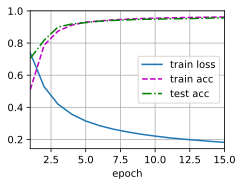

In [92]:
#数据加载

batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/cartoonvsnormal"
#计算平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_test_list,std_test_list=getmean_str(os.path.join(data_dir, 'test'),'test')
#计算cartoon集和normal集大小
cartoon_num=1.0*(len(os.listdir(os.path.join(data_dir, 'train','cartoon')))+len(os.listdir(os.path.join(data_dir, 'test','cartoon'))))
normal_num=1.0*(len(os.listdir(os.path.join(data_dir, 'train','normal')))+len(os.listdir(os.path.join(data_dir, 'test','normal'))))
#加载数据集
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
test_iter,image_test_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_test_list,std_test_list,batch_size)
index_classes = list(image_test_datasets.class_to_idx.keys())
print("类别一 {}，数量{}，类别二 {} 数量{}".format(index_classes[0],cartoon_num,index_classes[1],normal_num))
print("类别一 {}，数量{}，类别二 {} 数量{}".format(index_classes[0],cartoon_num,index_classes[1],normal_num))
#加载模型
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()#检测有无gpu

for parma in model.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model.fc.weight)

#是否使用gpu
if Use_gpu:
    model = model.cuda()

#损失函数和优化器
weight=torch.tensor([normal_num,cartoon_num])
weight=weight.cuda() if Use_gpu else weight
loss_f = torch.nn.CrossEntropyLoss(weight=weight)#不同类别数据量不同 添加权重来平衡
optimizer = torch.optim.SGD(model.fc.parameters(),lr = 1e-4)

num_epochs = 15
train_ch4_9(model, train_iter, test_iter, loss_f, num_epochs,optimizer,Use_gpu)
#清除内存
del model
torch.cuda.empty_cache()

In [2]:
def  covariate_shift_detector(input_image,model_pth='../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth'):
    softmax=nn.Softmax(dim = 1)
    Use_gpu = torch.cuda.is_available()
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(2048,2)
    model.load_state_dict(torch.load(model_pth))
    if Use_gpu:
        model = model.cuda()
    model.eval()
    beta=lambda x:min(x[0][0]/x[0][1],1.0)
    with torch.no_grad():
        if len(input_image)==1:
            output=beta(softmax(model(input_image)))
            
        else:
            output=torch.tensor(list(map(lambda x: beta(softmax(model(torch.unsqueeze(x,0)))),input_image )))
        del model
        torch.cuda.empty_cache()
        return output

In [94]:
#随机重取一个测试数据看看网络分类情况

testnum=random.randint(0,len(image_test_datasets)-1)
index_classes = list(image_test_datasets.class_to_idx.keys())
input_image=torch.unsqueeze(image_test_datasets[testnum][0],0)
if torch.cuda.is_available():
    input_image=input_image.cuda()
output=index_classes[0] if covariate_shift_detector(input_image)>=1 else index_classes[1]
print("testnum ",testnum," 推断类别：",output,"实际类别：",index_classes[image_test_datasets[testnum][1]])
del input_image

testnum  3182  推断类别： normal 实际类别： normal


In [96]:
gc.collect()#释放内存
Use_gpu = torch.cuda.is_available()
#是否使用gpu
if Use_gpu:
    torch.cuda.empty_cache()
    print('clear')
input_image=[i[0].cuda() for i in image_test_datasets] if torch.cuda.is_available() else [i[0] for i in image_test_datasets]
output=covariate_shift_detector(input_image)
test_label=torch.tensor([i[1] for i in image_test_datasets])
cartoonacc=torch.tensor(list(map(lambda x: 1 if x >=1 else 0 ,output-torch.mul(output,test_label)))).sum()/(len(test_label)-test_label.sum())
normalacc=torch.tensor(list(map(lambda x: 1 if 0<x < 1 else 0 ,torch.mul(output,test_label)))).sum()/(test_label.sum())
print('卡通图片预测正确率:{:.4f}% ,正常图片预测正确率:{:.4f}%'.format(100*cartoonacc,100*normalacc))
del input_image

clear
卡通图片预测正确率:92.7000% ,正常图片预测正确率:96.4250%


### 练习4.9.3

实现协变量偏移纠正。

**解答：**

 &emsp;&emsp;首先展示没有使用分类器来训练模型的结果，可以看到训练的后期，即使各个数据曲线已经趋平，训练准确率仍然高于测试准确率。

epoch10 Loss:0.1253 Train Acc:97.0950% Test Cartoon Acc:89.8000% Test Normal Acc:97.5200%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth over


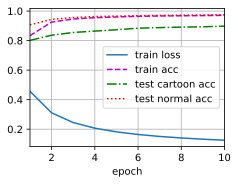

In [97]:
#import库 以及 用到的函数定义见4.9.2
#数据加载

batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_no_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()#检测是否有GPU

for parma in model_no_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_no_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_no_detector.fc.weight);


if Use_gpu:
    model_no_detector = model_no_detector.cuda()

#损失函数和优化器
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_no_detector.fc.parameters(),lr =  1e-4)

num_epochs = 10
train_ch4_9(model_no_detector, train_iter, testcartoon_iter, loss_f, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth')
#清除内存
del model_no_detector
torch.cuda.empty_cache()

epoch10 Loss:0.0668 Train Acc:90.6500% Test Cartoon Acc:83.6000% Test Normal Acc:90.9200%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth over


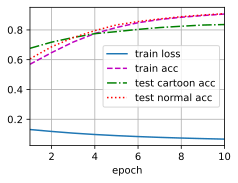

In [99]:
gc.collect()#内存清理
#数据加载
batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    torch.cuda.empty_cache()
    print('clear')
for parma in model_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_detector.fc.weight); 


if Use_gpu:
    model_detector = model_detector.cuda()

#损失函数和优化器
def myloss(y_hat,y,beta):
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    l=loss_f(y_hat,y)
    return torch.mul(beta,l).mean() 
    
    
optimizer = torch.optim.SGD(model_detector.fc.parameters(),lr =1e-4) 

num_epochs = 10
train_ch4_9(model_detector, train_iter, testcartoon_iter,myloss, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth',detector=covariate_shift_detector)
#清除内存
del model_detector
torch.cuda.empty_cache()

epoch10 Loss:0.4316 Train Acc:98.0200% Test Cartoon Acc:92.3600% Test Normal Acc:97.9600%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth over


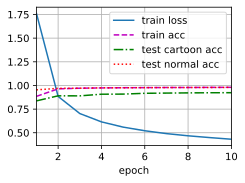

In [8]:
gc.collect()#内存清理
#数据加载
batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    #del modelwithoutdetector
    torch.cuda.empty_cache()
    print('clear')
for parma in model_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_detector.fc.weight);  # 对神经网络模型参数进行Xavier均匀分布初始化


if Use_gpu:
    model_detector = model_detector.cuda()

#损失函数和优化器
def myloss(y_hat,y,beta):
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    l=loss_f(y_hat,y)
    return 25*torch.mul(beta,l).mean() #直接使用beta计算结果 并没有改善 这可能是因为beta小于1 使loss变小 导致更新梯度以后 变化不大 所以乘以一个数 以改善这种情况
     
    
optimizer = torch.optim.SGD(model_detector.fc.parameters(),lr =1e-4) 

num_epochs = 10
train_ch4_9(model_detector, train_iter, testcartoon_iter,myloss, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth',detector=covariate_shift_detector)
#清除内存
del model_detector
torch.cuda.empty_cache()

In [9]:
gc.collect()
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    #del modelwithoutdetector
    torch.cuda.empty_cache()
    print('clear')
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
batch_size=32
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_detector.fc = torch.nn.Linear(2048,2)
model_detector.load_state_dict(torch.load('../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth'))
#加载模型没有分类器的模型
model_no_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_no_detector.fc = torch.nn.Linear(2048,2)
model_no_detector.load_state_dict(torch.load('../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth'))
print("没使用分类器测试准确率：{:.4f}%,使用分类器测试准确率：{:.4f}%".format(100*evaluate_accuracy_ch4_9(model_no_detector,testcartoon_iter,Use_gpu),100*evaluate_accuracy_ch4_9(model_detector, testcartoon_iter,Use_gpu)))
#清除内存
del model_no_detector
del model_detector
torch.cuda.empty_cache()

clear
testcartoon  mean: tensor([0.4168, 0.3945, 0.3463]) std: tensor([0.2118, 0.2033, 0.1590])
没使用分类器测试准确率：89.8000%,使用分类器测试准确率：92.3600%


### 练习4.9.4

除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

**解答：**

 &emsp;&emsp;除了分布偏移之外，还有以下因素可能会影响经验风险接近真实风险的程度：

1. 样本大小：经验风险的准确性通常随着样本大小的增加而增加。较大的样本量提供了更多的信息，使得估计的风险更加可靠。

2. 特征选择：选择恰当的特征可以减少噪声和冗余信息的影响，从而提高对真实风险的估计。良好的特征选择有助于提高模型的泛化能力。

3. 模型复杂度：模型的复杂度与其在训练数据上的表现以及对真实风险的估计密切相关。过于简单的模型可能无法捕捉到数据中的复杂关系，而过于复杂的模型可能过度拟合训练数据，导致经验风险与真实风险之间的差距增大。

4. 数据质量：数据质量对于经验风险的准确性至关重要。低质量的数据、含有错误或缺失值的数据可能导致错误的模型训练和风险估计。

5. 样本选择偏差：如果样本选择不恰当或存在偏差，例如采样方式不随机或样本并非代表总体，那么经验风险可能无法准确地估计真实风险。

6. 噪声和异常值：数据中的噪声和异常值可能对经验风险的估计造成干扰。这些异常值可能使模型过度拟合，并导致对真实风险的估计不准确。

&emsp;&emsp;请注意，这些因素的影响程度可能因具体情况而异，取决于数据集和建模方法的特点。

## 4.10 实战Kaggle比赛：预测房价

### 练习4.10.2

能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？

**解答：** 

&emsp;&emsp;直接预测价格的对数，可以得到不错的结果，不过由于取了对数所以误差函数的取值大小也变化了，要适当调小学习率。

In [8]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd
# 读取训练和测试数据
train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))
# 合并所有特征
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 标准化数据
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# 对类别特征进行独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)

n_train = train_data.shape[0]# 获取训练数据的数量
# 转换为PyTorch张量
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
in_features = train_features.shape[1]

# 初始化网络权重    
def init_weights(m):
    if type(m) == nn.Linear:
        m.reset_parameters()
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

#定义三个误差函数 
#loss 预测和标签的直接均方误差损失函数 loss_test 对测试集均方根误损失函数  log_rmse对测试集对数均方根误差测试函数
loss = nn.MSELoss()# 定义均方误差损失函数
# 定义对测试集均方根误损失函数
def loss_test(net,features, labels):
    return loss(net(features), labels).item()
# 定义对测试集对数均方根误差测试函数
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

# 训练函数
def train(net,l,train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size,test_func=log_rmse):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            get_loss = l(net(X),y)
            get_loss.backward()
            optimizer.step()
        net.eval()
      
        train_ls.append(test_func(net,train_features,train_labels))#(log_rmse(net, train_features, train_labels))
       
        if test_labels is not None:
                net.eval()
                test_ls.append(test_func(net,test_features, test_labels))#(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
# 获取K折数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
# K折交叉验证训练函数
def k_fold(l,net,k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size,show=1,test_func=log_rmse):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net.apply(init_weights)
        train_ls, valid_ls = train(net,l, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size,test_func=log_rmse)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if (i == 0)&(show==1):
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        if show==1:
            print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(l,train_features, test_features, train_labels, test_data,
        num_epochs, lr, weight_decay, batch_size,test_func=log_rmse):
    net = get_net()
    
    train_ls, _ = train(net,l,train_features, train_labels, None, None,
          num_epochs, lr, weight_decay, batch_size,test_func=loss_test)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
    ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将⽹络应⽤于测试集。
    preds = torch.exp(net(test_features)).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

折1，训练log rmse0.008091, 验证log rmse0.011202
折2，训练log rmse0.007515, 验证log rmse0.013859
折3，训练log rmse0.007449, 验证log rmse0.013520
折4，训练log rmse0.008128, 验证log rmse0.009966
折5，训练log rmse0.008152, 验证log rmse0.015174
5-折验证: 平均训练log rmse: 0.007867, 平均验证log rmse: 0.012744


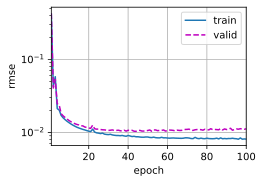

In [9]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64
log_labels=torch.log(train_labels)#对价格直接取对数 
train_l, valid_l = k_fold(loss,get_net(),k, train_features,log_labels  , num_epochs, lr,
                          weight_decay, batch_size,test_func=loss_test)# 此处直接优化 价格的对数均方根误差
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.009651


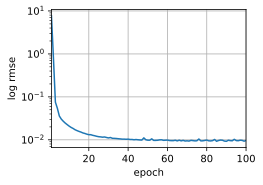

In [10]:
train_and_pred(loss,train_features, test_features, log_labels, test_data,
        num_epochs, lr, weight_decay, batch_size,test_func=log_rmse)
#得分0.15035

### 练习4.10.3

用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？

**解答：**

&emsp;&emsp;用平均值替换缺失值并不总是好主意，当数据中一个特征缺失值过多用大量的平均值代替，会改变该特征的真实数据分布从而在测试集上表现不好。最好的方法是根据具体情况制定缺失值替代方法，比如对于类型标签我们用数据的众数代替缺失值会比平均值代替好很多。同时对于一些分布出现数据是中位数的概率可能比数据是平均值更大所以更好的是用中位数替代缺失值。

&emsp;&emsp;以下我们用代码演示对缺失的数据用前后值或者插值法填充的训练结果。

折1，训练log rmse0.170187, 验证log rmse0.156665
折2，训练log rmse0.162936, 验证log rmse0.192074
折3，训练log rmse0.163925, 验证log rmse0.168308
折4，训练log rmse0.168358, 验证log rmse0.154775
折5，训练log rmse0.163274, 验证log rmse0.183363
5-折验证: 平均训练log rmse: 0.165736, 平均验证log rmse: 0.171037


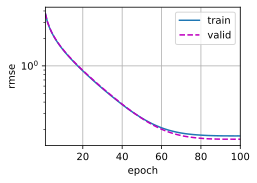

In [5]:
#import库 以及 用到的函数定义见4.10.2
all_features2 = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
numeric_features2 = all_features2.dtypes[all_features2.dtypes != 'object'].index

all_features2[numeric_features2] = all_features[numeric_features2].apply(
     lambda x: (x - x.mean()) / (x.std()))
# # 在标准化数据之后，我们用插值法替换缺失值
all_features2[numeric_features2] = all_features2[numeric_features2].interpolate()
all_features2 = pd.get_dummies(all_features2, dummy_na=True)
n_train = train_data.shape[0]
train_features2 = torch.tensor(all_features2[:n_train].values, dtype=torch.float32)
test_features2 = torch.tensor(all_features2[n_train:].values, dtype=torch.float32)
train_labels2 = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features2 = train_features2.shape[1]

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(loss,get_net(),k, train_features2, train_labels2, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 练习4.10.4

通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。

**解答：**

 &emsp;&emsp;取num_epochs, lr, batch_size,weight_decay  = 100, 15, 31,0 提交结果可以得到0.1504分值

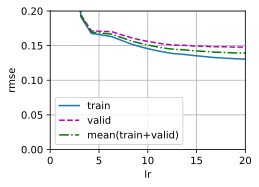

In [3]:
#import库 以及 用到的函数定义见4.10.2
k, num_epochs, weight_decay, batch_size = 5, 100, 0, 64
animator_lr = d2l.Animator(xlabel='lr', ylabel='rmse', xlim=[0,20], ylim=[0.0, 0.2],
                        legend=[ 'train ', 'valid ','mean(train+valid)'])
for lr in np.linspace(0.,20,20):
    train_l, valid_l = k_fold(loss,get_net(),k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,show=0)
    print(f'lr={float(lr):f}  {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
            f'平均验证log rmse: {float(valid_l):f}')
    animator_lr.add(lr, (train_l, valid_l,0.5*(train_l+valid_l)))

weight_decay_get:0,loss: 0.14236998856067656


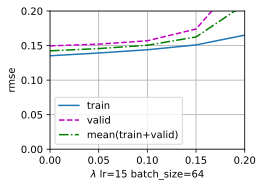

In [5]:
k, num_epochs, lr, batch_size = 5, 100, 15,  64 
animator_wd = d2l.Animator(xlabel=f'$\lambda$ lr={lr} batch_size={batch_size}', ylabel='rmse', xlim=[0,0.2], ylim=[0.0, 0.2],
                        legend=[ 'train ', 'valid ','mean(train+valid)'])
findmin=lambda x1,x2,y1,y2: (x1,y1) if y2>=y1 else (x2,y2)
weight_decay_get=0
for weight_decay in np.linspace(0.,0.2,5):
    train_l, valid_l = k_fold(loss,get_net(),k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,show=0)
    if weight_decay==0:
        l=0.5*(train_l+ valid_l)
    weight_decay_get,l=findmin( weight_decay_get,weight_decay,l,0.5*(train_l+ valid_l))
    print(f'weight_decay={float(weight_decay):f}  {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
            f'平均验证log rmse: {float(valid_l):f}')
    animator_wd.add(weight_decay, (train_l, valid_l,0.5*(train_l+valid_l)))
print(f'weight_decay_get:{weight_decay_get},loss: {l}')

batch_get:31,loss: 0.1366610862314701


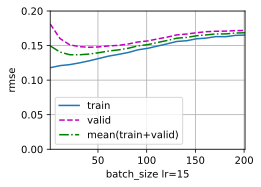

In [6]:
k, num_epochs, lr, weight_decay  = 5, 100,15,0
animator_batch_size = d2l.Animator(xlabel=f'batch_size lr={lr}', ylabel='rmse', xlim=[1,201], ylim=[0.0, 0.2],
                        legend=[ 'train ', 'valid ','mean(train+valid)'])
findmin=lambda x1,x2,y1,y2: (x1,y1) if y2>=y1 else (x2,y2)
batch_size_get=1
for batch_size in np.arange(1,202,10):
    train_l, valid_l = k_fold(loss,get_net(),k, train_features, train_labels, num_epochs, lr,
                          weight_decay,int(batch_size),show=0)
    if batch_size==1:
        l=0.5*(train_l+ valid_l)
    batch_size_get,l=findmin(batch_size_get,batch_size,l,0.5*(train_l+ valid_l))
    print(f'batch_size={batch_size}  {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
            f'平均验证log rmse: {float(valid_l):f}')
    animator_batch_size.add(batch_size, (train_l, valid_l,0.5*(train_l+valid_l)))
print(f'batch_get:{batch_size_get},loss: {l}')

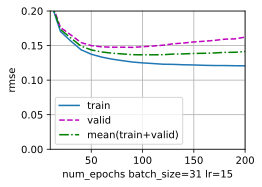

In [11]:
k, batch_size, lr, weight_decay  = 5, batch_size_get,15,0
animator_num_epochs = d2l.Animator(xlabel=f'num_epochs batch_size={batch_size} lr={lr}', ylabel='rmse', xlim=[10,200], ylim=[0.0, 0.2],
                        legend=[ 'train ', 'valid ','mean(train+valid)'])

for num_epochs in np.arange(10,210,10):
    train_l, valid_l = k_fold(loss,get_net(),k, train_features, train_labels, num_epochs, lr,
                          weight_decay,int(batch_size),show=0)
    print(f'num_epochs={num_epochs}  {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
            f'平均验证log rmse: {float(valid_l):f}')
    animator_num_epochs.add(num_epochs, (train_l, valid_l,0.5*(train_l+valid_l)))


训练log rmse：0.125640


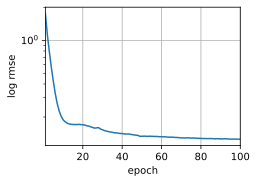

In [7]:
def train_and_pred(net,loss,train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,name='submission.csv',f=lambda x: x.detach().numpy()):
    #net = get_net()
    train_ls, _ = train(net,loss,train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    net.eval()
    preds = f(net(test_features))
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(name, index=False)
num_epochs, lr, batch_size,weight_decay  = 100, 15, 31,0
train_and_pred(get_net(),loss,train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,'../data/ch04-4-10-4-submission.csv')
#提交结果0.1504比原始好一些

### 练习4.10.5

通过改进模型（例如，层、权重衰减和dropout）来提高分数。

**解答：**

 &emsp;&emsp;构造一个3层的网络每层的隐藏单元数分别为165，82，41，并对最后两层分别取dropout为0.2，0.4，学习率为0.0001，训练轮次为100，batchsize为32的模型。提交计算的分数为0.14961。

折1，训练log rmse0.139646, 验证log rmse0.141831
折2，训练log rmse0.136683, 验证log rmse0.150859
折3，训练log rmse0.136523, 验证log rmse0.146661
折4，训练log rmse0.141830, 验证log rmse0.139160
折5，训练log rmse0.136660, 验证log rmse0.169688


(0.13826846182346345, 0.14963960349559785)

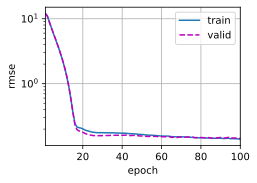

In [14]:
#import库 以及 用到的函数定义见4.10.2
def mynet(num_hiddens,dropout1,dropout2):
    net= nn.Sequential(nn.Linear(in_features,in_features),
                       nn.ReLU(),
                       #nn.Dropout(dropout1),
                       nn.Linear(in_features, int(0.5*in_features)),
                       nn.ReLU(),
                       nn.Dropout(dropout1),
                       nn.Linear(int(0.5*in_features), int(0.5*0.5*in_features)),
                       nn.ReLU(),
                       nn.Dropout(dropout2),
                       nn.Linear(int(0.5*0.5*in_features), num_hiddens),
                       nn.Linear(num_hiddens, 1))
    return net
k, num_hiddens,weight_decay, batch_size,dropout1,dropout2,num_epochs,lr= 5,int(0.5*0.5*0.5*in_features),0, 32,0.2,0.4,100,0.0001
k_fold(loss,mynet(int(num_hiddens),dropout1,dropout2),k, train_features,  train_labels, num_epochs, lr,
                          weight_decay, batch_size,show=1)


训练log rmse：0.135433


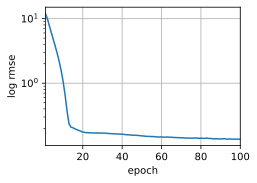

In [15]:
k, num_hiddens,weight_decay, batch_size,dropout1,dropout2,num_epochs,lr= 5,int(0.5*0.5*0.5*in_features),0, 32,0.2,0.4,100,0.0001

train_and_pred(mynet(int(num_hiddens),dropout1,dropout2),loss,train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,name='../data/ch04-4-10-5-submission.csv')
#得分0.14961

### 练习4.10.6

如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？

**解答：**

 &emsp;&emsp;会导致计算时候，模型对数值比较大的特征和数值比较小的特征关注度不一致，无法公平对待每一个特征，同时也可能导致数值不稳定无法训练。

折1，训练log rmse0.172671, 验证log rmse0.174495
折2，训练log rmse0.295084, 验证log rmse0.307665
折3，训练log rmse0.447330, 验证log rmse0.439771
折4，训练log rmse0.553742, 验证log rmse0.486329
折5，训练log rmse0.226638, 验证log rmse0.254015
5-折验证: 平均训练log rmse: 0.339093, 平均验证log rmse: 0.332455


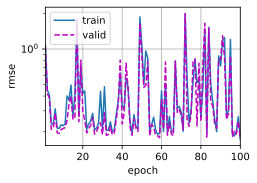

In [11]:
#import库 以及 用到的函数定义见4.10.2
#加载数据
all_features3 = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
numeric_features3 = all_features3.dtypes[all_features3.dtypes != 'object'].index
# 使用均值填充缺失值
all_features3[numeric_features3] = all_features3[numeric_features3].fillna(all_features3[numeric_features3].mean())
all_features3 = pd.get_dummies(all_features3, dummy_na=True)
n_train = train_data.shape[0]
train_features3 = torch.tensor(all_features3[:n_train].values, dtype=torch.float32)
test_features3 = torch.tensor(all_features3[n_train:].values, dtype=torch.float32)
train_labels3 = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features3 = train_features3.shape[1]
def get_net():
    net= nn.Sequential(nn.Linear(in_features3,1))
    return net
# 使用 k 折交叉验证
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(loss,get_net(),k, train_features3, train_labels3, num_epochs, lr,
                          weight_decay, batch_size)
# 打印验证结果
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
